# NBA Team Analytics Pipeline

## Necessary Imports

In [39]:
import time
import re
from PIL import Image
import requests
import urllib
import urllib.request
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.5g}'.format)
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import  OffsetImage

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [40]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
team_names =     ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
                  'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
                  'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
                  'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
                  'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
                  'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
                  'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
                  'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
                  'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
                  'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_abbrs =     ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
                  'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
                  'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
                  'NYK', 'MEM', 'ORL', 'NBA']

team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_id_dict={}

for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]]=team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]]=team_names[i]

## Webscrape and Clean NBA Team Data into Pandas DF

In [41]:
url = 'https://stats.nba.com/stats/leaguegamelog'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'T',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'}

jsonData = requests.get(url, headers=headers, params=payload).json()


rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

df = pd.DataFrame(rows, columns=columns)
df.drop(['VIDEO_AVAILABLE'], axis=1, inplace=True)


df['FG2M'] = df.FGM - df.FG3M
df['FG2A'] = df.FGA - df.FG3A

df['FG2_PTS'] = df.FG2M * 2
df['FG3_PTS'] = df.FG3M * 3

df['FRAC_ATT_2PT'] = df.FG2A / df.FGA
df['FRAC_ATT_3PT'] = df.FG3A / df.FGA

df['FRAC_MK_2PT'] = df.FG2M / df.FGM
df['FRAC_MK_3PT'] = df.FG3M / df.FGM

df['FRAC_PTS_2PT'] = df.FG2_PTS / df.PTS
df['FRAC_PTS_3PT'] = df.FG3_PTS / df.PTS
df['FRAC_PTS_FT'] = df.FTM / df.PTS 

df['OPP_TEAM_ABBR'] = df['MATCHUP'].str.strip().str[-3:]
df['OPP_PTS'] = df['PTS'] - df['PLUS_MINUS']

df['MONTH'] = pd.DatetimeIndex(df['GAME_DATE']).month
df['YEAR'] = pd.DatetimeIndex(df['GAME_DATE']).year

def home_or_away(string):
    if string[4]=='@': return 'AWAY'
    elif string[4]=='v': return 'HOME'
df['HOME_AWAY'] = df['MATCHUP'].map(home_or_away)

conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

df['CONFERENCE'] = df['TEAM_ABBREVIATION'].apply(lambda x: conferences.get(x))
df['OPP_CONFERENCE'] = df['OPP_TEAM_ABBR'].apply(lambda x: conferences.get(x))

# ADD OPONENTS RECORD ON GAME DATE
# ADD TEAM RECORD ON GAME DATE

df['DATE_MATCHUP'] = df['GAME_DATE'].str[5:] + ' ' + df['MATCHUP'].str[4:]
#df['DATE_MATCHUP'] = df['GAME_DATE'] + ' ' + df['MATCHUP'].str[4:]

df.TEAM_NAME = df.TEAM_ABBREVIATION.apply(lambda x: team_abbr_name_dict.get(x))

df.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME     GAME_ID  \
0     22022  1610612757               POR  Portland Trail Blazers  0022200647   
1     22022  1610612742               DAL        Dallas Mavericks  0022200647   
2     22022  1610612762               UTA               Utah Jazz  0022200646   
3     22022  1610612755               PHI      Philadelphia 76ers  0022200646   
4     22022  1610612739               CLE     Cleveland Cavaliers  0022200645   

    GAME_DATE      MATCHUP WL  MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  \
0  2023-01-14  POR vs. DAL  W  240   49   88   0.557    17    41    0.415   
1  2023-01-14    DAL @ POR  L  240   43   82   0.524    22    46    0.478   
2  2023-01-14  UTA vs. PHI  L  240   43   90   0.478    12    40      0.3   
3  2023-01-14    PHI @ UTA  W  240   40   89   0.449    17    39    0.436   
4  2023-01-14    CLE @ MIN  L  240   37   76   0.487     8    28    0.286   

   FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0   21   22   0.955    10    37   47   34    7    4   12  20  136          17   
1   11   19   0.579     2    23   25   28    4    3   11  18  119         -17   
2   19   23   0.826    10    38   48   20    5    6   12  24  117          -1   
3   21   26   0.808     9    28   37   23    5    5    8  17  118           1   
4   20   23    0.87     8    32   40   24    5    2   18  17  102          -8   

   FG2M  FG2A  FG2_PTS  FG3_PTS  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  \
0    32    47       64       51       0.53409       0.46591      0.65306   
1    21    36       42       66       0.43902       0.56098      0.48837   
2    31    50       62       36       0.55556       0.44444      0.72093   
3    23    50       46       51        0.5618        0.4382        0.575   
4    29    48       58       24       0.63158       0.36842      0.78378   

   FRAC_MK_3PT  FRAC_PTS_2PT  FRAC_PTS_3PT  FRAC_PTS_FT OPP_TEAM_ABBR  \
0      0.34694       0.47059         0.375      0.15441           DAL   
1      0.51163       0.35294       0.55462     0.092437           POR   
2      0.27907       0.52991       0.30769      0.16239           PHI   
3        0.425       0.38983        0.4322      0.17797           UTA   
4      0.21622       0.56863       0.23529      0.19608           MIN   

   OPP_PTS  MONTH  YEAR HOME_AWAY CONFERENCE OPP_CONFERENCE   DATE_MATCHUP  
0      119      1  2023      HOME       WEST           WEST  01-14 vs. DAL  
1      136      1  2023      AWAY       WEST           WEST    01-14 @ POR  
2      118      1  2023      HOME       WEST           EAST  01-14 vs. PHI  
3      117      1  2023      AWAY       EAST           WEST    01-14 @ UTA  
4      110      1  2023      AWAY       EAST           WEST    01-14 @ MIN

In [42]:
ids = list(df.TEAM_ID.unique())
teams = list(df.TEAM_NAME.unique())

for i in range(len(teams)):
    team_id_dict[teams[i]]=ids[i]

## Create team averages dataframes for offense and defense

In [43]:
pivot_team_avg = pd.pivot_table(df, index=['TEAM_NAME','TEAM_ABBREVIATION'], aggfunc = 'mean')
df_team_avg = pivot_team_avg.reset_index()
df_team_avg.loc[30] = df_team_avg.drop(['TEAM_NAME','TEAM_ABBREVIATION'], axis=1).mean()
df_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_team_avg = df_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})


pivot_defense_allowed_team_avg = pd.pivot_table(df, index=['OPP_TEAM_ABBR'], aggfunc = 'mean')
df_defense_allowed_team_avg = pivot_defense_allowed_team_avg.reset_index()
df_defense_allowed_team_avg.loc[30] = df_defense_allowed_team_avg.drop(['OPP_TEAM_ABBR'], axis=1).mean()
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBREVIATION'})
df_defense_allowed_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_defense_allowed_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_defense_allowed_team_avg['TEAM_NAME'] = df_defense_allowed_team_avg['TEAM_ABBREVIATION'].map(team_abbr_name_dict)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.drop(['YEAR','TEAM_ID'], axis=1)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_defense_allowed_team_avg = df_defense_allowed_team_avg[cols_to_move + [x for x in df_defense_allowed_team_avg.columns if x not in cols_to_move]]
df_defense_allowed_team_avg.rename(columns=lambda x: 'OPP_'+x, inplace=True)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBR','OPP_TEAM_NAME':'TEAM_NAME'})

df_team_avg = pd.merge(df_team_avg, 
                       df_defense_allowed_team_avg,
                       right_on='TEAM_ABBR',
                       left_on='TEAM_ABBR',
                       how='left')
df_team_avg = df_team_avg.drop(['TEAM_NAME_y', 'OPP_PTS_y'],axis=1)
df_team_avg = df_team_avg.rename(columns={'TEAM_NAME_x':'TEAM_NAME','OPP_PTS_x':'OPP_PTS'})

cols_to_move = ['TEAM_NAME', 'TEAM_ABBR', 'PTS']
df_team_avg = df_team_avg[cols_to_move + [x for x in df_team_avg.columns if x not in cols_to_move]]


df_team_avg

TEAM_NAME TEAM_ABBR    PTS    AST    BLK   DREB   FG2A  \
0            Atlanta Hawks       ATL 114.93 23.953 5.0698 33.651 61.605   
1           Boston Celtics       BOS  118.5  26.75 5.3864 34.818 46.432   
2            Brooklyn Nets       BKN 114.17 26.341 7.0244 32.854 52.805   
3        Charlotte Hornets       CHA 112.02 25.273 4.9318 33.182 59.205   
4            Chicago Bulls       CHI 114.14 24.302 4.7209 33.744 58.163   
5      Cleveland Cavaliers       CLE  111.5 23.636 4.0455 32.841 52.841   
6         Dallas Mavericks       DAL 112.45 21.909 4.1818 31.409 42.091   
7           Denver Nuggets       DEN    117 28.595 4.4048 33.238 55.405   
8          Detroit Pistons       DET  112.3   22.5 3.5652 31.522  54.87   
9    Golden State Warriors       GSW 117.31 29.238  3.881     34 46.786   
10         Houston Rockets       HOU 109.33     22 4.5476 33.452 52.952   
11          Indiana Pacers       IND 115.39 26.773 5.9773 32.295 50.932   
12    Los Angeles Clippers       LAC 109.09 22.795 4.5455 34.091 51.909   
13      Los Angeles Lakers       LAL 116.62 24.952 4.6905 35.762 58.524   
14       Memphis Grizzlies       MEM 117.12 25.286  6.119 36.024 59.857   
15              Miami Heat       MIA 108.82 23.409 3.0909 31.341 50.795   
16         Milwaukee Bucks       MIL 111.77 24.465 5.1628 36.698 50.419   
17  Minnesota Timberwolves       MIN  114.8  25.25 5.2045   32.5 54.114   
18    New Orleans Pelicans       NOP 117.33 26.023 4.3953 33.698 58.256   
19         New York Knicks       NYK 114.05 22.698 4.2093 34.372 55.093   
20   Oklahoma City Thunder       OKC 116.91 24.326  5.186 32.767 59.093   
21           Orlando Magic       ORL 110.35 22.256 4.6977 33.023  53.93   
22      Philadelphia 76ers       PHI 113.81 24.952 4.9048 32.143 51.238   
23            Phoenix Suns       PHX 112.73 26.568 4.9318 31.318 56.295   
24  Portland Trail Blazers       POR 112.64 24.214 4.1905 32.643 50.833   
25        Sacramento Kings       SAC 119.68 27.146 3.3171 33.098 50.537   
26       San Antonio Spurs       SAS 112.47  27.07 4.2326  30.93 59.395   
27         Toronto Raptors       TOR 111.77 23.047 5.0465 29.977 57.558   
28               Utah Jazz       UTA 117.39 25.804 4.8043 32.478 49.696   
29      Washington Wizards       WAS  111.7 24.698 5.3256 34.744 55.279   
30          League Average       NBA 113.94 24.874 4.7264 33.154 53.897   

     FG2M  FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  FG_PCT  \
0  32.907   65.814 30.884 10.419  0.33884   31.256 92.488 43.326  0.4696   
1   26.75     53.5 41.909 15.455   0.3675   46.364 88.341 42.205 0.47895   
2  30.659   61.317 31.146 12.195  0.39144   36.585 83.951 42.854 0.51076   
3   30.75     61.5 33.568 11.023    0.328   33.068 92.773 41.773 0.45152   
4  31.674   63.349 29.023 10.814  0.36795   32.442 87.186 42.488   0.488   
5  29.273   58.545 31.591 11.386  0.36366   34.159 84.432 40.659 0.48384   
6  24.364   48.727 41.023  14.75   0.3605    44.25 83.114 39.114 0.47195   
7    31.5       63 30.714  12.31  0.39712   36.929 86.119  43.81 0.51024   
8   28.13   56.261 32.761 11.674  0.35248   35.022  87.63 39.804 0.45439   
9  26.381   52.762 43.476  16.19  0.37181   48.571 90.262 42.571 0.47219   
10 27.476   54.952 35.405 11.738  0.32543   35.214 88.357 39.214 0.44426   
11 27.114   54.227 38.818 14.068  0.36186   42.205  89.75 41.182  0.4605   
12 27.023   54.045 33.455 12.318  0.36786   36.955 85.364 39.341 0.46293   
13 32.738   65.476 30.762 10.381  0.34117   31.143 89.286 43.119 0.48421   
14 32.286   64.571 32.857 11.476  0.34998   34.429 92.714 43.762 0.47238   
15     27       54 35.909 12.205     0.34   36.614 86.705 39.205 0.45234   
16 26.907   53.814 39.302 13.674  0.35016   41.023 89.721 40.581 0.45393   
17 31.432   62.864 32.091 11.114   0.3472   33.341 86.205 42.545 0.49582   
18 31.558   63.116 30.814 11.233   0.3613   33.698  89.07 42.791 0.48202   
19 29.186   58.372 35.209 11.907  0.33751   35.721 90.302 41.093 0.45551   
20 31.233   62.465 3

In [44]:
df_defense_allowed_team_avg.head()

TEAM_NAME TEAM_ABBR  OPP_AST  OPP_BLK  OPP_DREB  OPP_FG2A  \
0      Atlanta Hawks       ATL   25.372   5.3023    35.837    57.465   
1      Brooklyn Nets       BKN   22.805   3.8049    31.976    55.341   
2     Boston Celtics       BOS   22.477   3.7727    34.091    57.477   
3  Charlotte Hornets       CHA   26.636   6.1818    35.409    53.636   
4      Chicago Bulls       CHI   26.233   5.1628    34.163    51.372   

   OPP_FG2M  OPP_FG2_PTS  OPP_FG3A  OPP_FG3M  OPP_FG3_PCT  OPP_FG3_PTS  \
0    31.256       62.512     32.93    11.256      0.34077       33.767   
1    27.927       55.854    32.805    11.976      0.36398       35.927   
2     30.75         61.5      32.5    11.545      0.35514       34.636   
3    30.068       60.136     35.75    12.909      0.35852       38.727   
4    28.465        56.93    36.581    13.442      0.36751       40.326   

   OPP_FGA  OPP_FGM  OPP_FG_PCT  OPP_FRAC_ATT_2PT  OPP_FRAC_ATT_3PT  \
0   90.395   42.512     0.47202           0.63625           0.36375   
1   88.146   39.902     0.45324           0.62585           0.37415   
2   89.977   42.295     0.47098           0.63829           0.36171   
3   89.386   42.977     0.48211            0.5995            0.4005   
4   87.953   41.907     0.47835           0.58454           0.41546   

   OPP_FRAC_MK_2PT  OPP_FRAC_MK_3PT  OPP_FRAC_PTS_2PT  OPP_FRAC_PTS_3PT  \
0          0.73637          0.26363           0.54025            0.2893   
1          0.69738          0.30262           0.50593           0.32398   
2          0.72718          0.27282           0.54953           0.30764   
3          0.69844          0.30156           0.50783           0.32493   
4          0.67846          0.32154           0.49584           0.34966   

   OPP_FRAC_PTS_FT  OPP_FTA  OPP_FTM  OPP_FT_PCT  OPP_MIN  OPP_MONTH  \
0          0.17044   24.442   19.628     0.80009   242.91     9.5349   
1          0.17009   24.561    18.78     0.76461   240.61     9.9268   
2          0.14283     20.5   16.023     0.78061   242.27     9.3636   
3          0.16724   25.386   19.818     0.78623   243.41     9.6136   
4          0.15451   22.977    17.86     0.77851   242.91     9.5581   

   OPP_OPP_PTS  OPP_OREB  OPP_PF  OPP_PLUS_MINUS  OPP_PTS  OPP_REB  OPP_STL  \
0       114.93    11.372  20.209         0.97674   115.91   47.209    7.186   
1       114.17    11.439  18.073         -3.6098   110.56   43.415    7.439   
2        118.5    9.6591  19.795         -6.3409   112.16    43.75   6.3409   
3       112.02    10.727  20.659          6.6591   118.68   46.136   6.7045   
4       114.14    9.6744  19.093         0.97674   115.12   43.837   6.5349   

   OPP_TOV  
0   14.977  
1   14.366  
2    13.25  
3   14.977  
4   14.837

## Advanced Shooting Analytics Dataframe

In [45]:
tables = pd.read_html("https://www.basketball-reference.com/leagues/NBA_2023.html#shooting-team")

df_team_advshot = tables[12]
df_team_advshot.columns = [' '.join(col) for col in df_team_advshot.columns]
df_team_advshot.columns = df_team_advshot.columns.str.replace("Unnamed:", "")
df_team_advshot.columns = df_team_advshot.columns.str.replace("_level_0", "")
df_team_advshot = df_team_advshot.drop([' 0 Rk',
                                        ' 6  6_level_1',
                                        ' 13  13_level_1',
                                        ' 20  20_level_1',
                                        ' 23  23_level_1',
                                        ' 26  26_level_1',
                                        ' 29  29_level_1'], axis=1)

df_team_advshot = df_team_advshot.rename(columns={' 1 Team':'TEAM_NAME',
                                                  ' 2 G':'G',
                                                  ' 3 MP':'MP',
                                                  ' 4 FG%':'FG%',
                                                  ' 5 Dist.':'Dist'})


df_team_advshot['TEAM_ABBR'] = df_team_advshot['TEAM_NAME']
df_team_advshot['TEAM_ABBR']=df_team_advshot['TEAM_ABBR'].map(team_name_abbr_dict)

cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_team_advshot = df_team_advshot[cols_to_move + [x for x in df_team_advshot.columns if x not in cols_to_move]]


df_team_advshot.head()

TEAM_NAME TEAM_ABBR   G     MP   FG%  Dist  \
0      Atlanta Hawks       ATL  43  10445  0.47  13.3   
1     Boston Celtics       BOS  44  10660  0.47  14.2   
2      Brooklyn Nets       BKN  41   9865 0.453  13.4   
3      Chicago Bulls       CHI  43  10445 0.476  14.3   
4  Charlotte Hornets       CHA  44  10710 0.481  14.1   

   % of FGA by Distance 2P  % of FGA by Distance 0-3  \
0                    0.636                      0.29   
1                    0.639                     0.206   
2                    0.628                     0.277   
3                    0.584                      0.27   
4                      0.6                     0.264   

   % of FGA by Distance 3-10  % of FGA by Distance 10-16  \
0                      0.176                         0.1   
1                      0.224                       0.113   
2                      0.201                       0.086   
3                      0.166                       0.086   
4                      0.184                       0.088   

   % of FGA by Distance 16-3P  % of FGA by Distance 3P  FG% by Distance 2P  \
0                       0.069                    0.364               0.544   
1                       0.096                    0.361               0.535   
2                       0.063                    0.372               0.505   
3                       0.062                    0.416               0.554   
4                       0.064                      0.4               0.561   

   FG% by Distance 0-3  FG% by Distance 3-10  FG% by Distance 10-16  \
0                0.688                 0.435                  0.407   
1                0.688                 0.464                  0.442   
2                0.662                 0.383                  0.381   
3                0.693                 0.456                  0.433   
4                0.681                 0.462                  0.465   

   FG% by Distance 16-3P  FG% by Distance 3P  % of FG Ast'd 2P  \
0                  0.413               0.342             0.505   
1                   0.48               0.355             0.447   
2                  0.371               0.365             0.463   
3                   0.38               0.367             0.523   
4                  0.478               0.361             0.516   

   % of FG Ast'd 3P  Dunks %FGA  Dunks Md.  Layups %FGA  Layups Md.  \
0             0.851       0.065        231        0.292         652   
1             0.756       0.051        184        0.276         597   
2             0.825       0.054        179          0.3         568   
3             0.844       0.062        217        0.266         589   
4             0.861       0.065        218        0.271         587   

   Corner %3PA  Corner 3P%  
0         0.23        0.38  
1        0.173       0.375  
2        0.232       0.391  
3        0.246       0.344  
4        0.254       0.419

In [46]:
#['% of FG Ast'd 2P', '% of FG Ast'd 3P']

## Function Field Goal Trends based on Distance

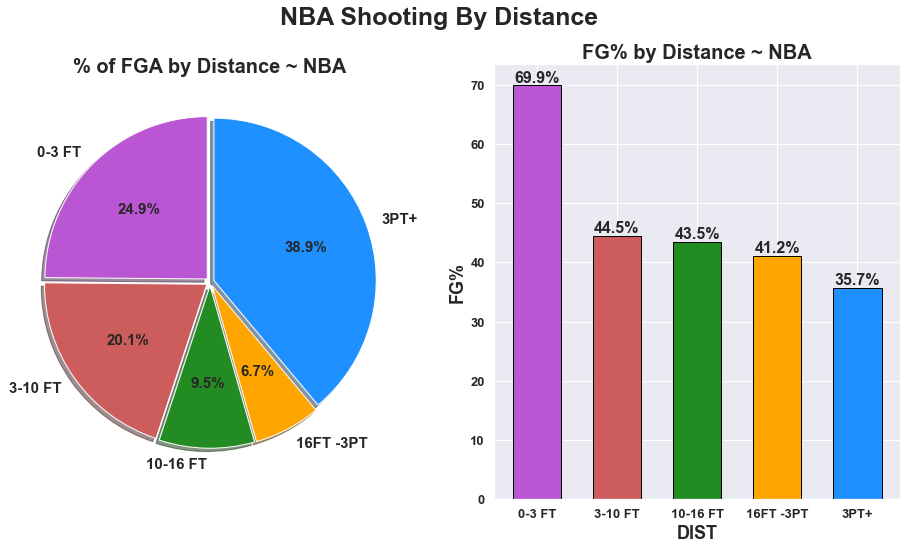

In [47]:
def nba_fg_by_dist():
    plt.rcParams["figure.figsize"] = (10,10)
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']

    att_dist_data = df_team_advshot[['% of FGA by Distance 0-3',
                             '% of FGA by Distance 3-10', 
                             '% of FGA by Distance 10-16', 
                             '% of FGA by Distance 16-3P', 
                             '% of FGA by Distance 3P']].mean()
    
    
    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    ax[0].pie(att_dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title('% of FGA by Distance ~ NBA', fontsize=20, fontweight='bold')
    
    per_dist_data = df_team_advshot[['FG% by Distance 0-3',
                                     'FG% by Distance 3-10',
                                     'FG% by Distance 10-16',
                                     'FG% by Distance 16-3P',
                                     'FG% by Distance 3P']].mean()*100
    
    per_dist = list(per_dist_data.keys())
    per_values = list(per_dist_data)
    
    barWidth = 0.6
    
    ax[1].bar(per_dist, per_values, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title('FG% by Distance ~ NBA', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
        
    plt.suptitle('NBA Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
nba_fg_by_dist()

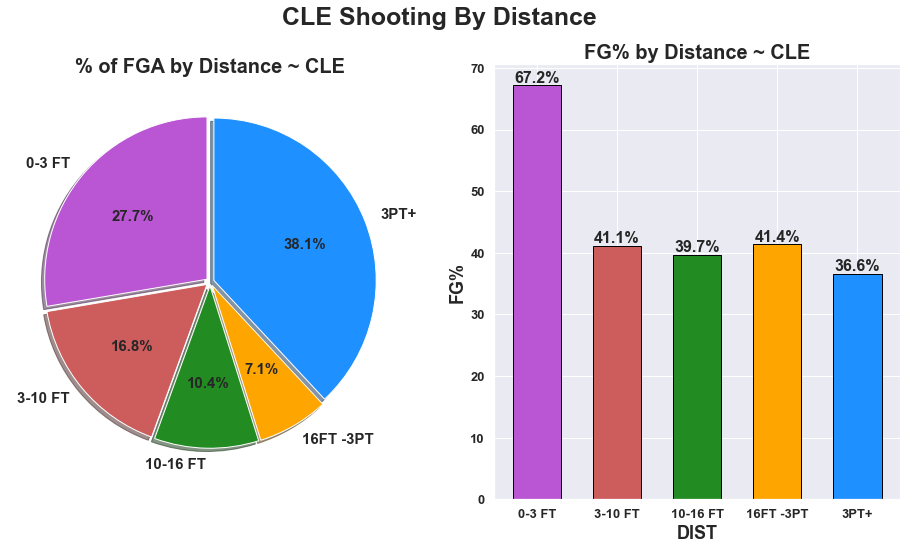

In [48]:
def team_fg_by_dist(abbr):
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']
    barWidth = 0.6
    
    plt.rcParams["figure.figsize"] = (10,10)
    
    dist_data = list(np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3P'].item()]))
    
    dist_data_pct = np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3P'].item()])*100

    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax[0].pie(dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title(f'% of FGA by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    
    ax[1].bar(labels, dist_data_pct, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title(f'FG% by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
    
    plt.suptitle(f'{abbr} Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
team_fg_by_dist('CLE')

## Function to return a teams dataframe

In [49]:
def get_team_df(TEAM_ABBR):
    team_df = df[df['TEAM_ABBREVIATION']==TEAM_ABBR]
    return team_df

## Webscrape NBA records data into a pandas dataframe

In [50]:
columns = ['TEAM_ABBR','CONFERENCE','GAMES','WINS','LOSES','WIN_PER','LAST_10_WINS','LAST_10_LOSES','HOME_WINS','HOME_LOSES','AWAY_WINS','AWAY_LOSES',
           'WEST_WINS', 'WEST_LOSES', 'EAST_WINS', 'EAST_LOSES']
data_records=[]
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

for i in df.TEAM_ABBREVIATION.unique(): 
    
    team_abbr = i
    
    games = df[(df['TEAM_ABBREVIATION']==i)]['WL'].count() 
    
    wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')]['WL'].count()
    loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')]['WL'].count()
    
    win_per = wins/games
    
    last_10_df = get_team_df(i).head(10)
    
    last_10_wins = last_10_df[last_10_df['WL']=='W']['WL'].count()
    last_10_loses = last_10_df[last_10_df['WL']=='L']['WL'].count()
    
    home_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    home_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    
    away_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    away_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    
    west_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    west_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    
    east_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    east_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    
    conference = conferences[i]
    
    values = [team_abbr, conference, games, wins, loses, win_per, last_10_wins, last_10_loses, home_wins, home_loses, away_wins, away_loses,
              west_wins, west_loses, east_wins, east_loses]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data_records.append(a_dictionary)
    
df_records=pd.DataFrame(data_records).sort_values('WINS',ascending=False).reset_index(drop=True)


df_records.loc[30] = df_records[df_records.drop(['TEAM_ABBR', 'CONFERENCE'], axis=1).columns].mean()

df_records.loc[30, 'TEAM_ABBR']='NBA'
df_records.loc[30, 'CONFERENCE']='NBA'


df_records

TEAM_ABBR CONFERENCE  GAMES   WINS  LOSES  WIN_PER  LAST_10_WINS  \
0        BOS       EAST     44     32     12  0.72727             8   
1        DEN       WEST     42     29     13  0.69048             8   
2        MEM       WEST     42     29     13  0.69048             9   
3        BKN       EAST     41     27     14  0.65854             8   
4        CLE       EAST     44     27     17  0.61364             5   
5        MIL       EAST     43     27     16  0.62791             5   
6        PHI       EAST     42     26     16  0.61905             6   
7        NOP       EAST     43     26     17  0.60465             5   
8        NYK       EAST     43     24     19  0.55814             6   
9        MIA       EAST     44     24     20  0.54545             7   
10       DAL       WEST     44     24     20  0.54545             6   
11       IND       EAST     44     23     21  0.52273             6   
12       SAC       WEST     41     23     18  0.56098             6   
13       LAC       WEST     44     22     22      0.5             3   
14       UTA       WEST     46     22     24  0.47826             3   
15       MIN       WEST     44     22     22      0.5             6   
16       PHX       WEST     44     21     23  0.47727             2   
17       ATL       EAST     43     21     22  0.48837             4   
18       GSW       WEST     42     21     21      0.5             6   
19       OKC       WEST     43     20     23  0.46512             6   
20       POR       WEST     42     20     22  0.47619             3   
21       CHI       EAST     43     19     24  0.44186             5   
22       TOR       EAST     43     19     24  0.44186             4   
23       LAL       WEST     42     19     23  0.45238             6   
24       WAS       EAST     43     18     25   0.4186             6   
25       ORL       EAST     43     16     27  0.37209             4   
26       SAS       WEST     43     13     30  0.30233             2   
27       DET       EAST     46     12     34  0.26087             4   
28       CHA       EAST     44     11     33     0.25             2   
29       HOU       WEST     42     10     32   0.2381             1   
30       NBA        NBA 43.133 21.567 21.567  0.50094        5.0667   

    LAST_10_LOSES  HOME_WINS  HOME_LOSES  AWAY_WINS  AWAY_LOSES  WEST_WINS  \
0               2         17           5         15           7         12   
1               2         18           3         11          10         22   
2               1         18           3         11          10         12   
3               2         13           6         14           8          6   
4               5         18           4          9          13         10   
5               5         16           5         11          11         11   
6               4         17           7          9           9          8   
7               5         17           5          9          12         16   
8               4         11          11         13           8          9   
9               3         14           9         10          11         14   
10              4         16           6          8          14         17   
11              4         15           9          8          12          6   
12              4         14           9          9           9         11   
13              7         12          10         10          12         12   
14              7         14           8          8          16         13   
15              4         14           9          8          13         14   
16              8         14           7          7          16         16   
17              6         11           9         10          13          5   
18              4         17           5          4          16         13   
19              4         13           9          7          14         10   
20              7         10           8         10          14         13   
21            

## Merge Records DF onto Team Averages DF

In [51]:
df_team_avg = pd.merge(df_team_avg, 
                         df_records,
                         left_on='TEAM_ABBR',
                         right_on='TEAM_ABBR',
                         how='left')
df_team_avg.head()

TEAM_NAME TEAM_ABBR    PTS    AST    BLK   DREB   FG2A   FG2M  \
0      Atlanta Hawks       ATL 114.93 23.953 5.0698 33.651 61.605 32.907   
1     Boston Celtics       BOS  118.5  26.75 5.3864 34.818 46.432  26.75   
2      Brooklyn Nets       BKN 114.17 26.341 7.0244 32.854 52.805 30.659   
3  Charlotte Hornets       CHA 112.02 25.273 4.9318 33.182 59.205  30.75   
4      Chicago Bulls       CHI 114.14 24.302 4.7209 33.744 58.163 31.674   

   FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  FG_PCT  \
0   65.814 30.884 10.419  0.33884   31.256 92.488 43.326  0.4696   
1     53.5 41.909 15.455   0.3675   46.364 88.341 42.205 0.47895   
2   61.317 31.146 12.195  0.39144   36.585 83.951 42.854 0.51076   
3     61.5 33.568 11.023    0.328   33.068 92.773 41.773 0.45152   
4   63.349 29.023 10.814  0.36795   32.442 87.186 42.488   0.488   

   FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0       0.66475       0.33525      0.75662      0.24338       0.57173   
1       0.52517       0.47483      0.63407      0.36593       0.45182   
2        0.6275        0.3725      0.71376      0.28624       0.53584   
3       0.63854       0.36146      0.73622      0.26378       0.54996   
4         0.666         0.334      0.74576      0.25424       0.55645   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  MONTH  OPP_PTS  \
0       0.27258      0.15569 21.791  17.86 0.81995 242.91 9.5349   115.91   
1       0.38949      0.15869 22.477 18.636 0.83427 242.27 9.3636   112.16   
2       0.32054      0.14362 20.268 16.268 0.80278 240.61 9.9268   110.56   
3       0.29319      0.15685 23.295 17.455 0.74464 243.41 9.6136   118.68   
4       0.28301      0.16055 22.488 18.349 0.81033 242.91 9.5581   115.12   

    OREB     PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV   YEAR  OPP_AST  \
0 10.442 19.326    -0.97674 44.093      7 1.6106e+09 12.814 2022.2   25.372   
1 9.4545 18.705      6.3409 44.273    6.5 1.6106e+09 13.318 2022.2   22.477   
2 7.4146  21.61      3.6098 40.268 7.1463 1.6106e+09 14.537 2022.1   22.805   
3 12.341 21.273     -6.6591 45.523 7.7273 1.6106e+09 13.955 2022.2   26.636   
4 8.5116 19.767    -0.97674 42.256 7.3953 1.6106e+09 13.744 2022.2   26.233   

   OPP_BLK  OPP_DREB  OPP_FG2A  OPP_FG2M  OPP_FG2_PTS  OPP_FG3A  OPP_FG3M  \
0   5.3023    35.837    57.465    31.256       62.512     32.93    11.256   
1   3.7727    34.091    57.477     30.75         61.5      32.5    11.545   
2   3.8049    31.976    55.341    27.927       55.854    32.805    11.976   
3   6.1818    35.409    53.636    30.068       60.136     35.75    12.909   
4   5.1628    34.163    51.372    28.465        56.93    36.581    13.442   

   OPP_FG3_PCT  OPP_FG3_PTS  OPP_FGA  OPP_FGM  OPP_FG_PCT  OPP_FRAC_ATT_2PT  \
0      0.34077       33.767   90.395   42.512     0.47202           0.63625   
1      0.35514       34.636   89.977   42.295     0.47098           0.63829   
2      0.36398       35.927   88.146   39.902     0.45324           0.62585   
3      0.35852       38.727   89.386   42.977     0.48211            0.5995   
4      0.36751       40.326   87.953   41.907     0.47835           0.58454   

   OPP_FRAC_ATT_3PT  OPP_FRAC_MK_2PT  OPP_FRAC_MK_3PT  OPP_FRAC_PTS_2PT  \
0           0.36375          0.73637          0.26363           0.54025   
1           0.36171          0.72718          0.27282           0.54953   
2           0.37415          0.69738          0.30262           0.50593   
3            0.4005          0.69844          0.30156           0.50783   
4           0.41546          0.67846          0.32154           0.49584   

   OPP_FRAC_PTS_3PT  OPP_FRAC_PTS_FT  OPP_FTA  OPP_FTM  OPP_FT_PCT  OPP_MIN  \
0            0.2893          0.17044   24.442   19.628     0.80009   242.91   
1           0.30764          0.14283     20.5   16.023     0.78061   242.27   
2           0.32398          0.17009   24.561    18.78     0.76461   240.61   
3           0.32493          0.16724   25.386   19.818     0.78

## NBA Team PPG BoxPlot Function

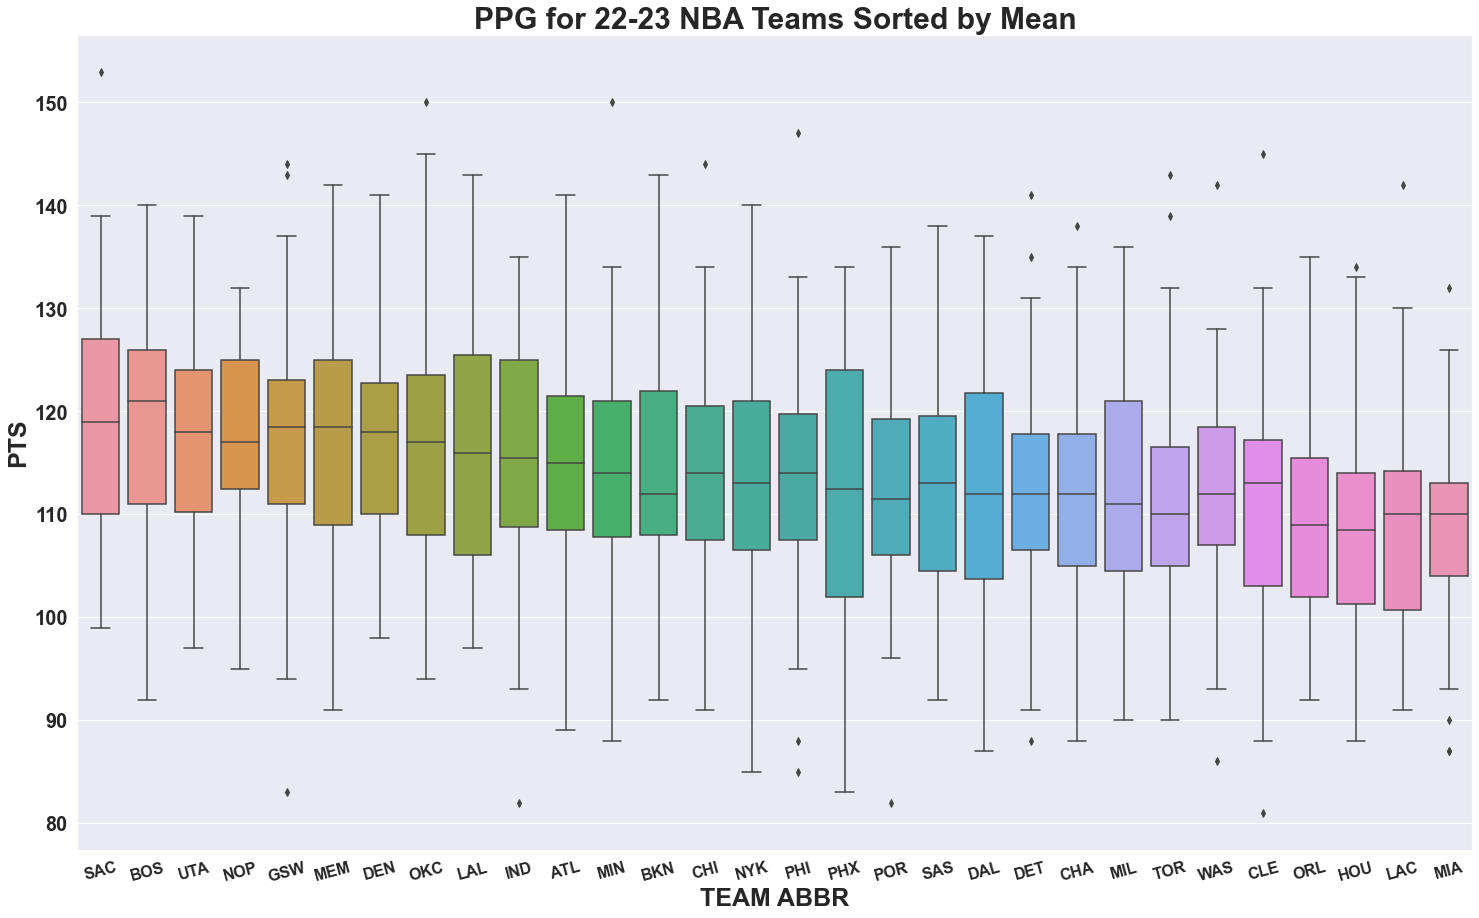

In [66]:
def team_ppg_boxplots():
    fig, (ax1) = plt.subplots(1, 1)

    sns.set(rc={'figure.figsize':(25,15)})

    means_ppg = df.groupby(['TEAM_ABBREVIATION'])['PTS'].mean().sort_values(ascending=[False])
    sns.boxplot(data=df, x=df.TEAM_ABBREVIATION, y='PTS', order=means_ppg.index, ax=ax1)
    ax1.set_title('PPG for 22-23 NBA Teams Sorted by Mean', fontsize=30, fontweight='bold')

    #medians_ppg = df.groupby(['TEAM_ABBREVIATION'])['PTS'].median().sort_values(ascending=[False])
    #sns.boxplot(data=df, x=df.TEAM_ABBREVIATION, y='PTS', order=medians_ppg.index, ax=ax2)
    #ax2.set_title('PPG for 22-23 NBA Teams Sorted by Median', fontsize=20)

    plt.xticks(rotation=15, fontsize=16, fontweight='bold')
    plt.xlabel('TEAM ABBR', fontsize=25, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')

    plt.ylabel('PTS', fontsize=25, fontweight='bold')


    plt.show()

team_ppg_boxplots()

## NBA Points Allowed Box Plot Function

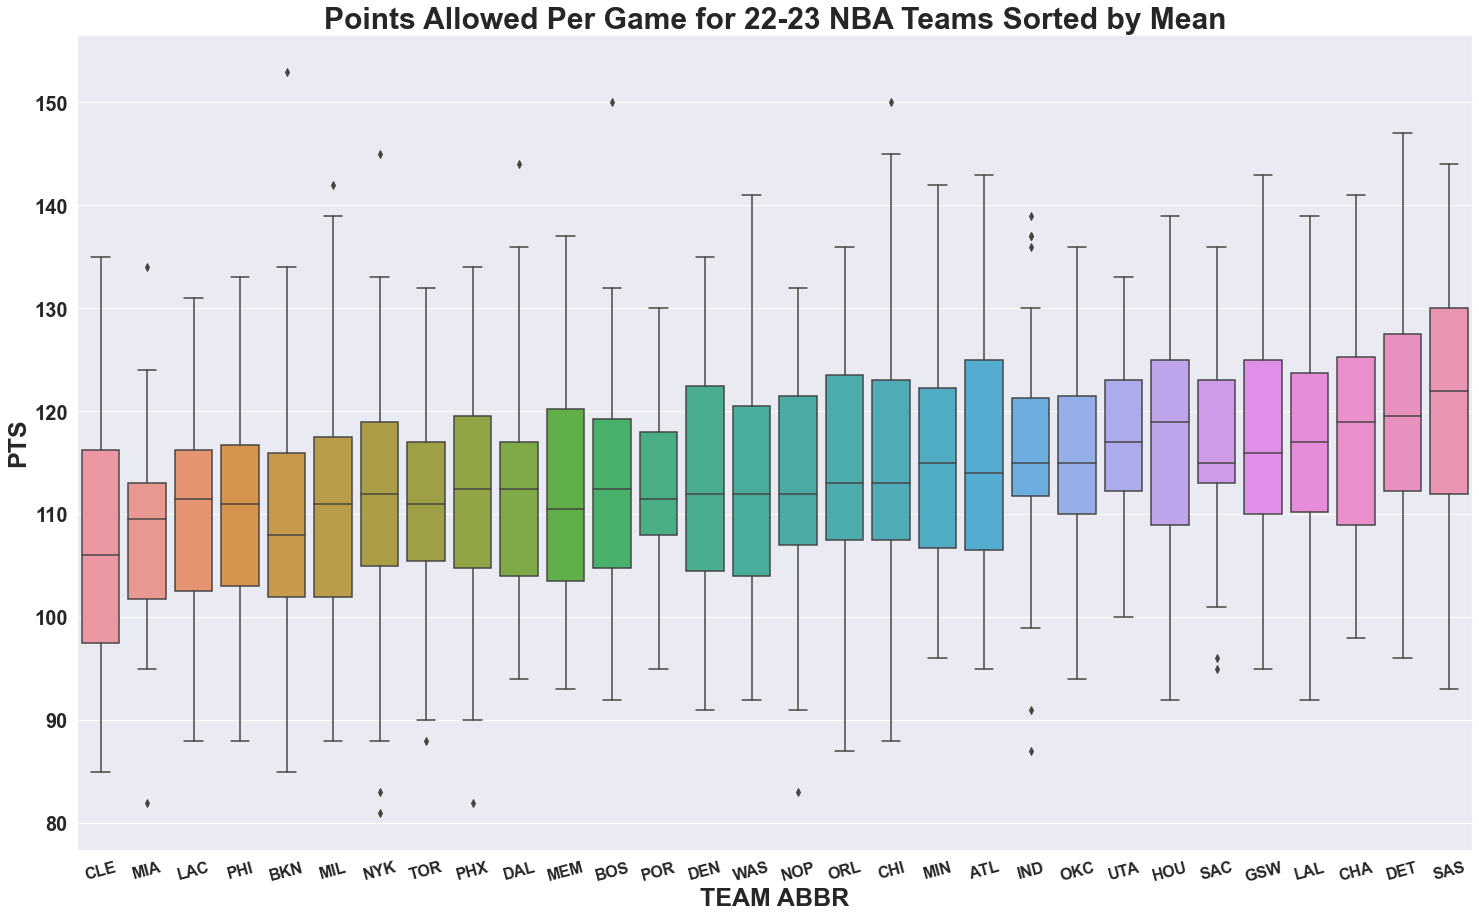

In [53]:
def pts_allowed_boxplots():
    fig, (ax1) = plt.subplots(1, 1)

    sns.set(rc={'figure.figsize':(25,15)})

    means_ppg = df.groupby(['OPP_TEAM_ABBR'])['PTS'].mean().sort_values(ascending=[True])
    sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y='PTS', order=means_ppg.index, ax=ax1)
    ax1.set_title('Points Allowed Per Game for 22-23 NBA Teams Sorted by Mean', fontsize=30, fontweight='bold')

    #medians_ppg = df.groupby(['OPP_TEAM_ABBR'])['PTS'].median().sort_values(ascending=[True])
    #sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y='PTS', order=medians_ppg.index, ax=ax2)
    #ax2.set_title('Points Allowed Per Game for 22-23 NBA Teams Sorted by Medians', fontsize=20)

    plt.xticks(rotation=15, fontsize=16, fontweight='bold')
    plt.xlabel('TEAM ABBR', fontsize=25, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')

    plt.ylabel('PTS', fontsize=25, fontweight='bold')

    plt.show()

pts_allowed_boxplots()

## Plus-Minus Plot Function

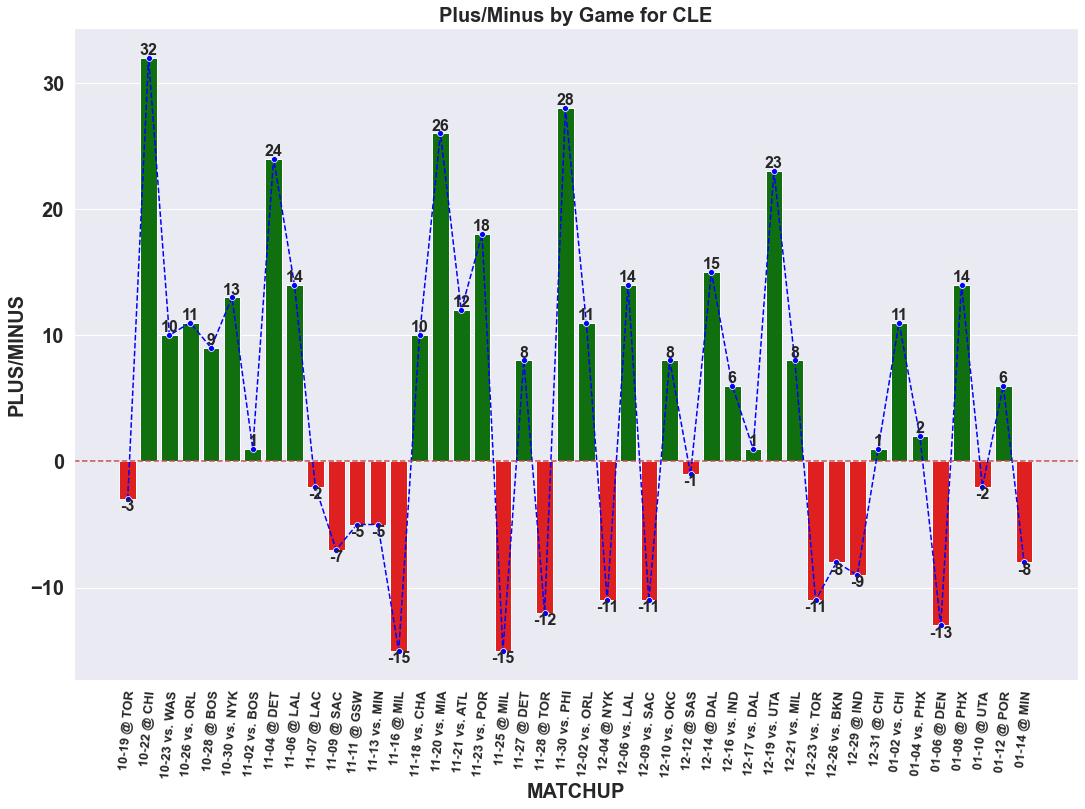

In [54]:
def plus_minus_plot(team_abbr):
    sns.set(rc={'figure.figsize':(18,12)})

    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    values = np.array(df.PLUS_MINUS)
    pal = ['green' if (i > 0) else 'red' for i in values ]
    
    ax1=sns.barplot(data=df, x=df.index, y=values, palette=pal)
    
    ax1.bar_label(ax1.containers[0], fontsize=16, fontweight='bold')
    plt.title(f"Plus/Minus by Game for {team_abbr}", fontsize=20, fontweight='bold')

    ax2=sns.lineplot(data=df, x=df.index, y="PLUS_MINUS",linestyle='--',color='blue', marker='o')
    plt.xticks(rotation=85)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.xticks(df.index,df["DATE_MATCHUP"].values, fontsize=13, fontweight='bold')
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')
    plt.ylabel('PLUS/MINUS', fontsize=20, fontweight='bold')

    plt.show()
    
plus_minus_plot('CLE')

## Scored vs Allowed Violin Plot Function

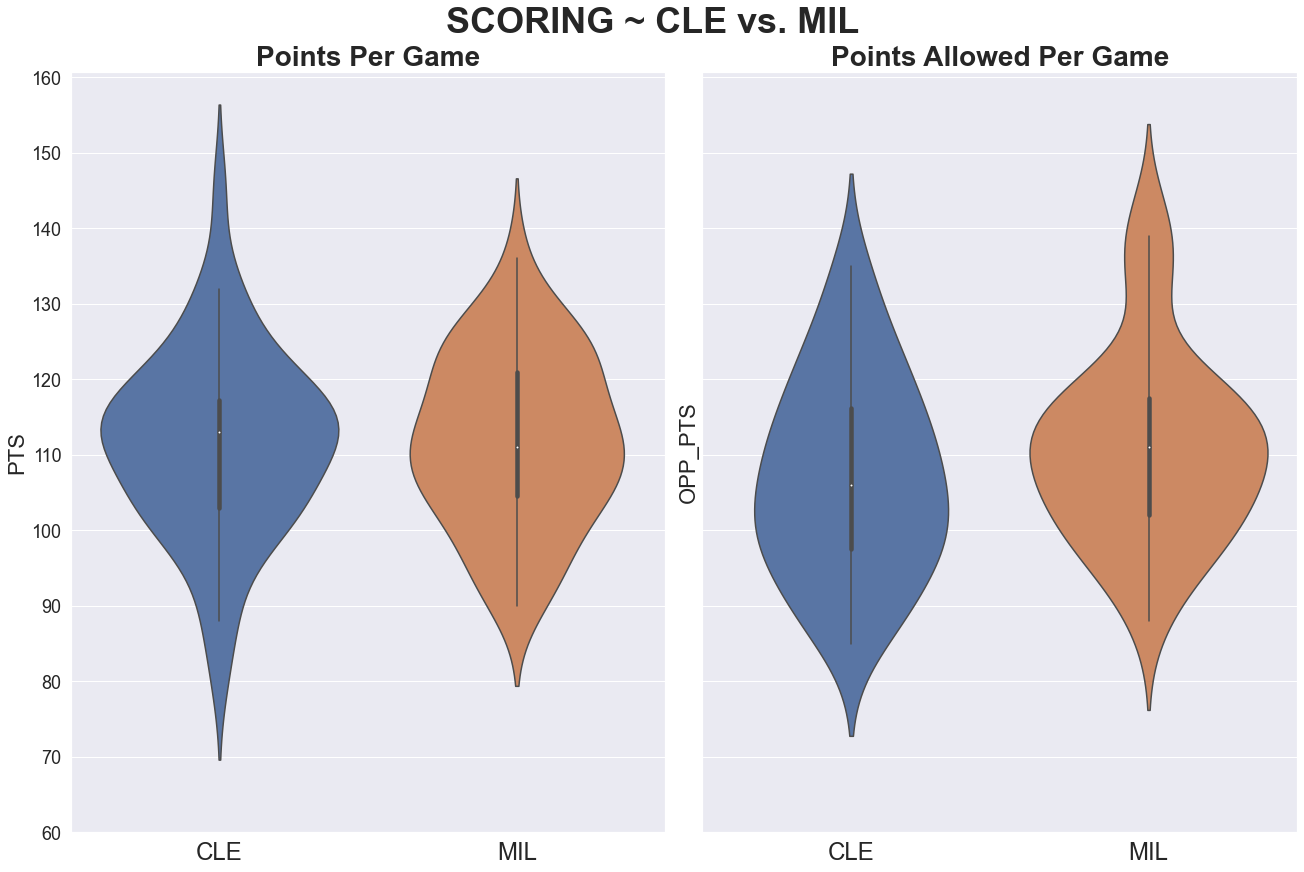

In [55]:
def scored_allowed_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    fig, axs = plt.subplots(ncols=2, sharey=True, constrained_layout=True)
    sns.set(rc={'figure.figsize':(18,12)})

    ax2 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OPP_PTS', ax=axs[1])
    ax2.set_title('Points Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.tick_params(axis='x', which='major', labelsize=24)
    ax2.set_xlabel('')
    ax2.set_ylabel('OPP_PTS', fontsize=22)

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='PTS', ax=axs[0])
    ax1.set_title('Points Per Game', fontsize=28, fontweight='bold')
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)
    ax1.set_ylabel('PTS', fontsize=22)
    ax1.set_xlabel('')

    plt.yticks([60,70,80,90,100,110,120,130,140,150,160])
    fig.suptitle(f'SCORING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=36, fontweight='bold')
    plt.show()
    
scored_allowed_compare("CLE", "MIL")

## Wins vs Losses Pie Charts Function

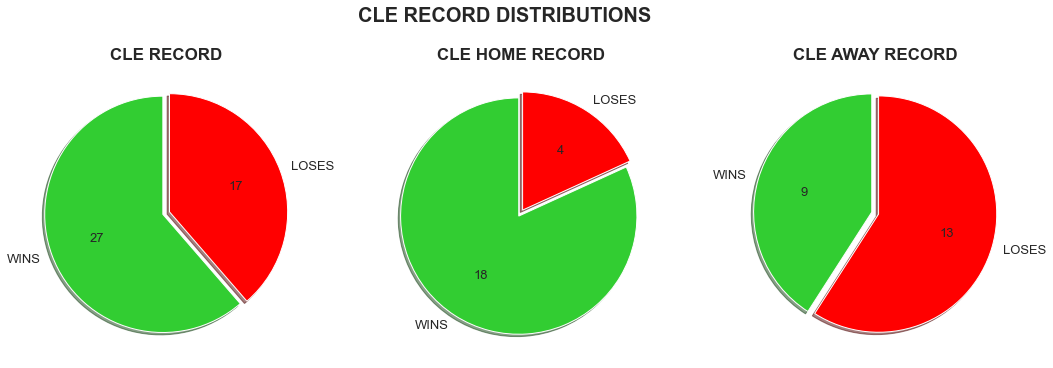

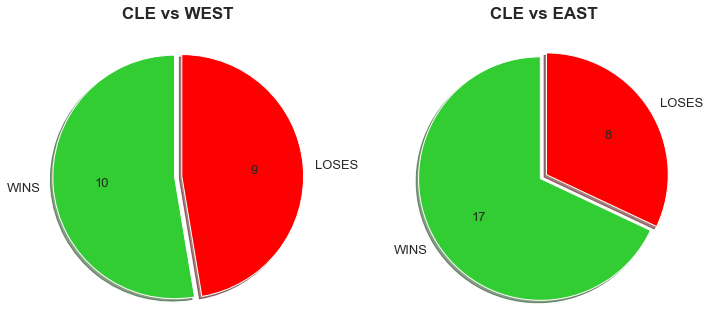

In [56]:
def wl_pies(team_abbr):
    wl_data = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].LOSES.item()])
    wl_data_home = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].HOME_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].HOME_LOSES.item()])
    wl_data_away = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].AWAY_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].AWAY_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl(val):
        a  = np.round(val/100.*wl_data.sum(), 0)
        return int(a)

    def absolute_value_wl_home(val):
        a  = np.round(val/100.*wl_data_home.sum(), 0)
        return int(a)

    def absolute_value_wl_away(val):
        a  = np.round(val/100.*wl_data_away.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


    ax[0].pie(wl_data,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} RECORD", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_home,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_home,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} HOME RECORD", fontsize= 17, fontweight='bold')

    ax[2].pie(wl_data_away,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_away,
            textprops={'fontsize': 13})
    ax[2].set_title(f"{team_abbr} AWAY RECORD", fontsize= 17, fontweight='bold')

    fig.suptitle(f'{team_abbr} RECORD DISTRIBUTIONS', fontsize=20, fontweight="bold")

    wl_pies_EW(team_abbr)

    plt.show()


def wl_pies_EW(team_abbr):
    wl_data_east = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].EAST_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].EAST_LOSES.item()])
    wl_data_west = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].WEST_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].WEST_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl_east(val):
        a  = np.round(val/100.*wl_data_east.sum(), 0)
        return int(a)

    def absolute_value_wl_west(val):
        a  = np.round(val/100.*wl_data_west.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


    ax[0].pie(wl_data_west,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_west,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} vs WEST", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_east,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_east,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} vs EAST", fontsize= 17, fontweight='bold')

    plt.show()
    
wl_pies("CLE")

## Multi Team Violin Plot Comparsion Function

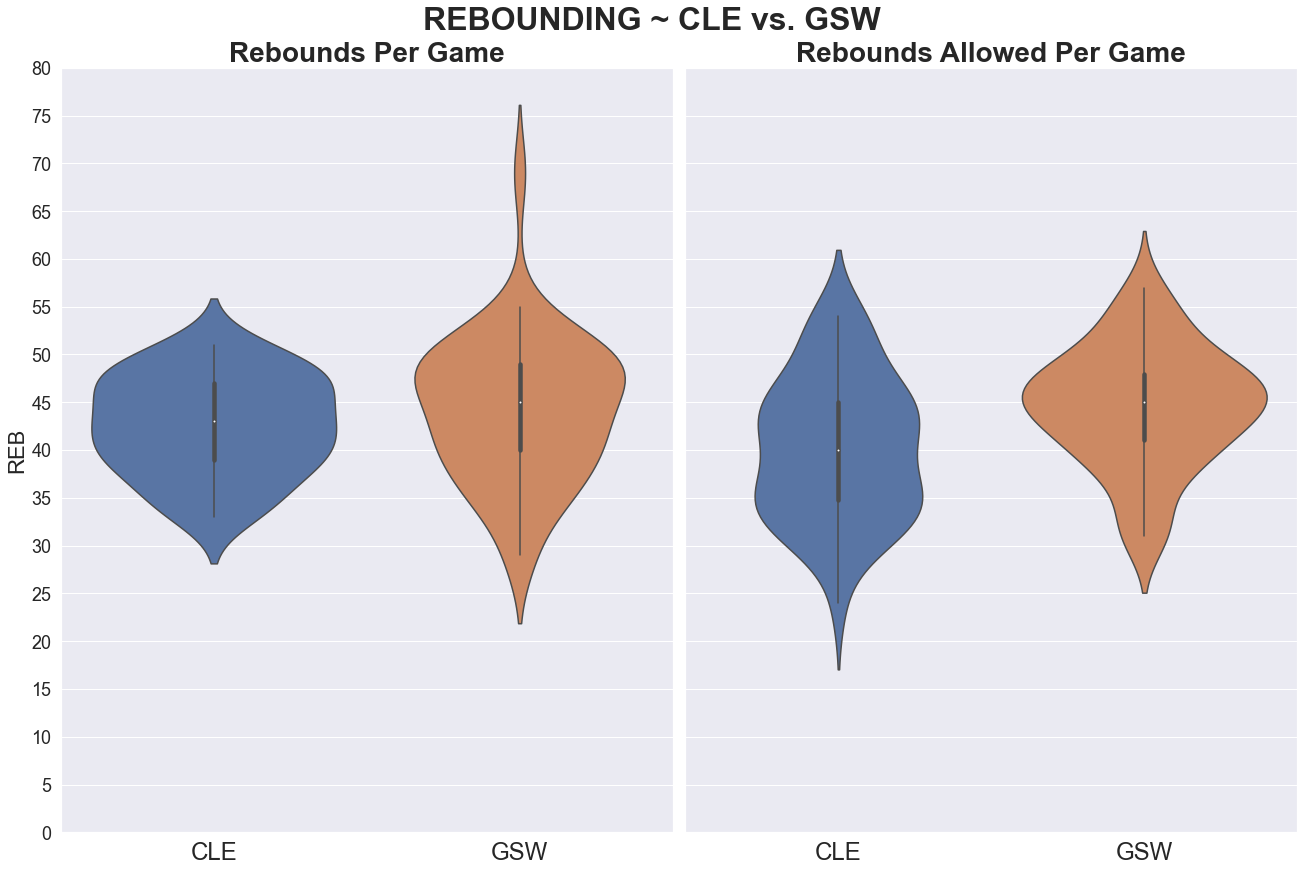

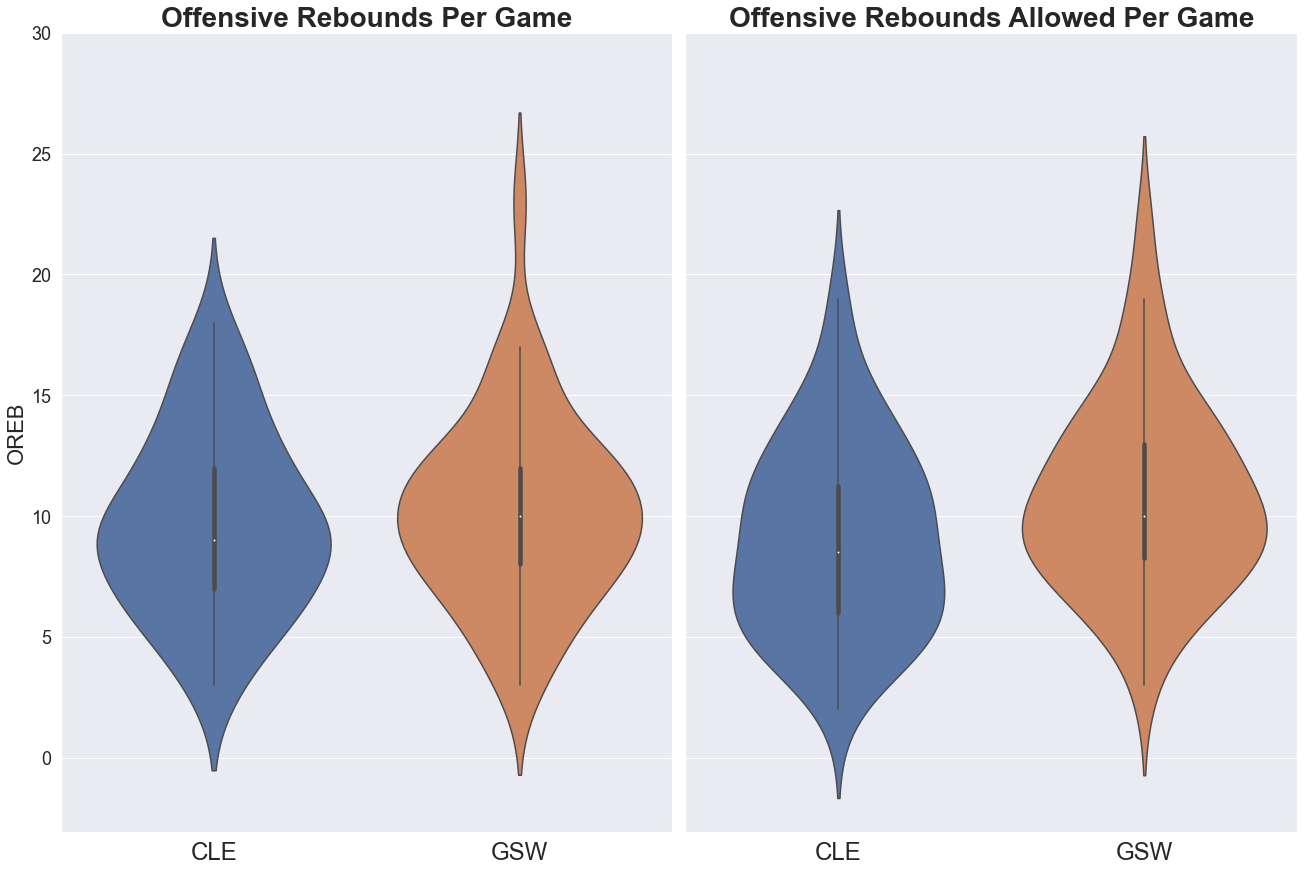

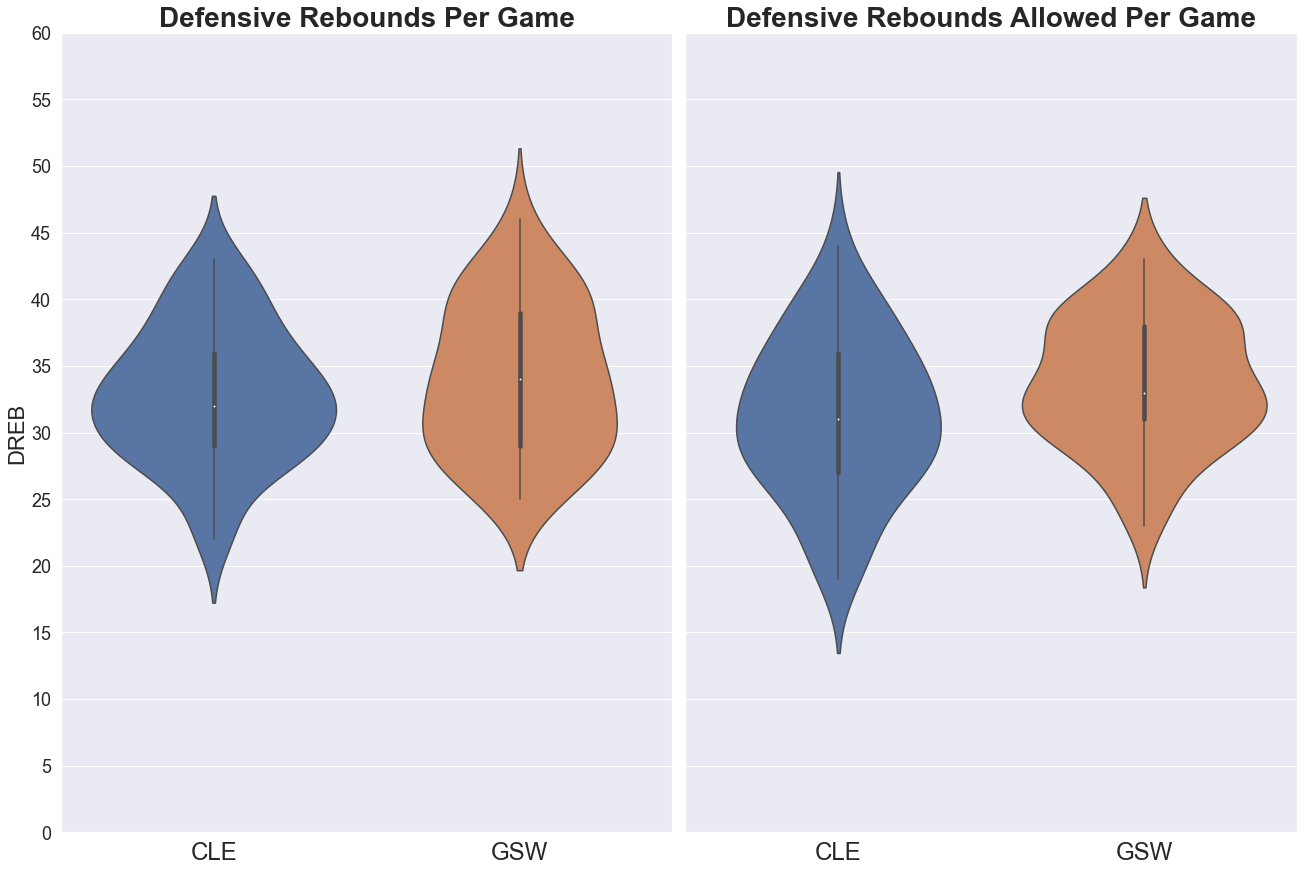

In [57]:
def rebounds_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='REB', ax=axs[0])
    ax1.set_title(f'Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('REB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='REB', ax=axs[1])
    ax2.set_title(f'Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40, 45, 50, 55, 60, 65, 70, 75, 80])

    fig.suptitle(f'REBOUNDING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=32, fontweight='extra bold')
    plt.show()

    print()
    oreb_compare(team_a_abbr,team_b_abbr)
    print()
    dreb_compare(team_a_abbr,team_b_abbr)
    print()

    # ADD REBOUNDING DIFFERENTIALS

def oreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OREB', ax=axs[0])
    ax1.set_title(f'Offensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('OREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='OREB', ax=axs[1])
    ax2.set_title(f'Offensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30])

    plt.show()

def dreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='DREB', ax=axs[0])
    ax1.set_title(f'Defensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('DREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='DREB', ax=axs[1])
    ax2.set_title(f'Defensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])

    plt.show()
    
rebounds_compare('CLE','GSW')

## Team Scoring Line Plot Function

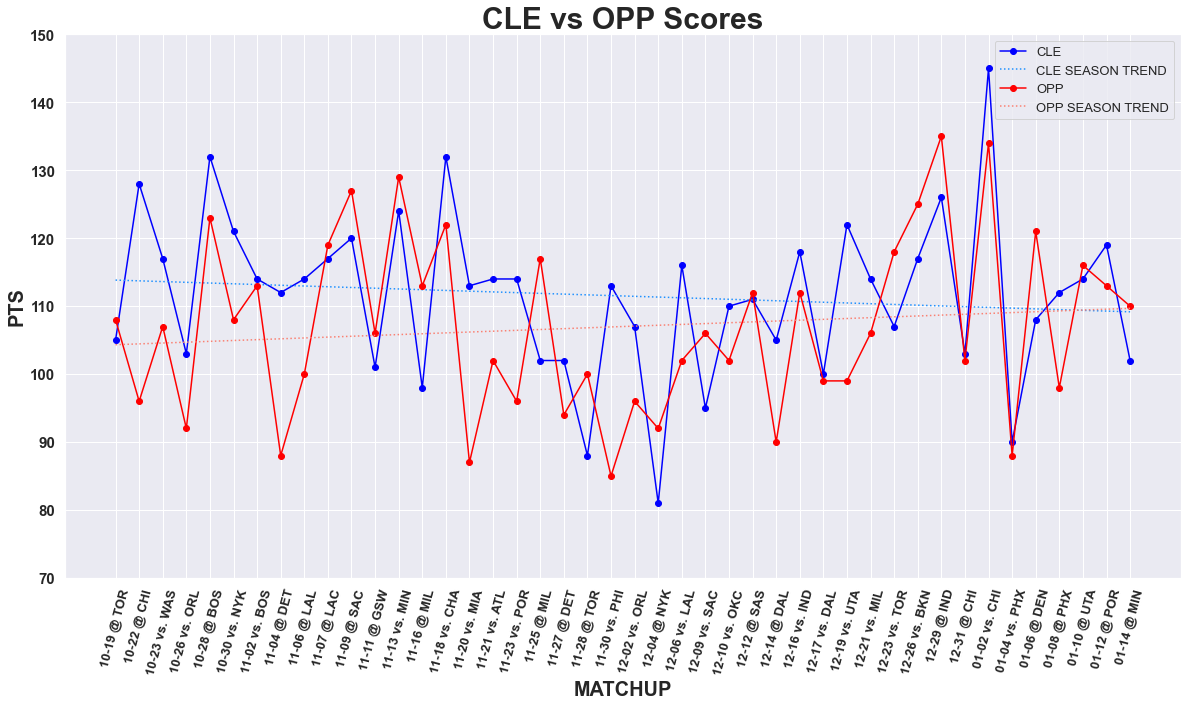

In [58]:
def line_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    team_score = plt.plot(df.index, df['PTS'], marker='o', label=team_abbr, color='blue')
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=1.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    opp_score = plt.plot(df.index, df['OPP_PTS'], marker='o', label='OPP', color='red')
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=1.5, color='salmon', label='OPP SEASON TREND')
    
    plt.legend(loc='best', fontsize=13)
    plt.title(f'{team_abbr} vs OPP Scores',fontsize=30, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15, fontweight='bold')
    plt.ylim(70, 150)
    plt.xlabel('MATCHUP',fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
line_plot_scores("CLE")

## Trend Plot Scores Function

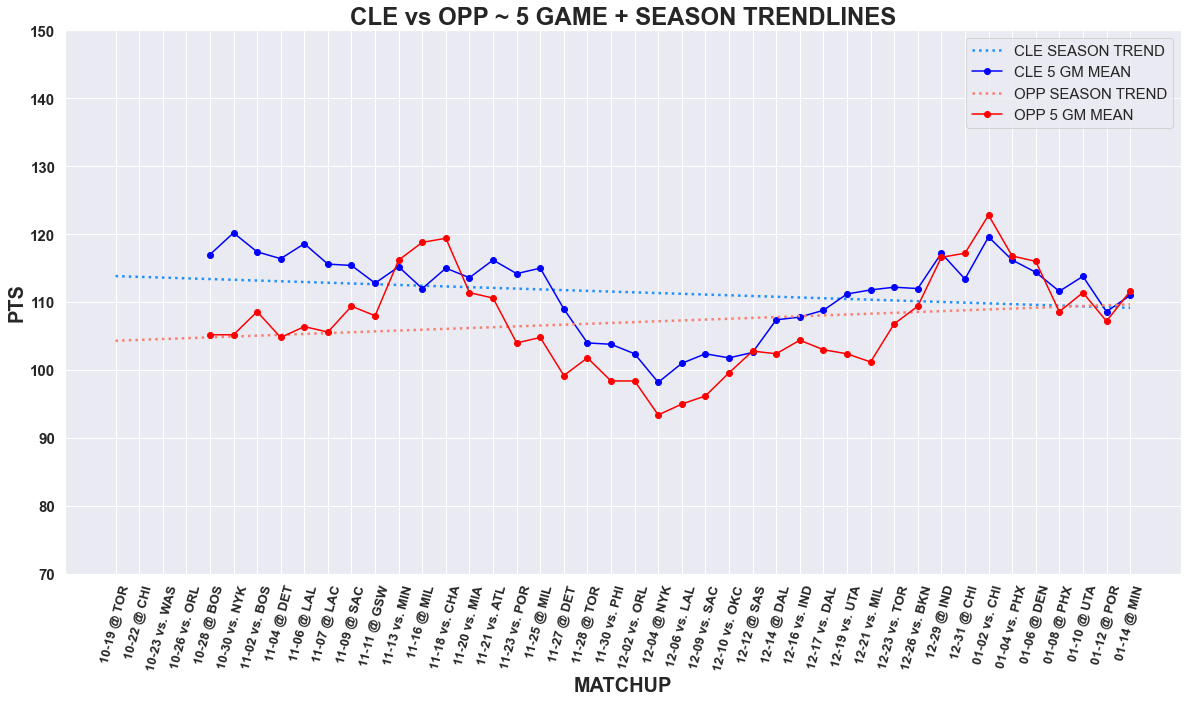

In [59]:
def trend_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=2.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    rolling_mean = df.PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="BLUE", alpha=1,marker='o', label=f"{team_abbr} 5 GM MEAN")
    
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=2.5, color='salmon', label='OPP SEASON TREND')
    
    rolling_mean = df.OPP_PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="RED", alpha=1,marker='o', label=f"OPP 5 GM MEAN")
    
    plt.legend(loc='best', fontsize=15)
    plt.title(f'{team_abbr} vs OPP ~ 5 GAME + SEASON TRENDLINES',fontsize=24, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15,  fontweight='bold')
    plt.ylim(70, 150)
    
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
trend_plot_scores("CLE")

## Shooting Distribution Pie Chart Function

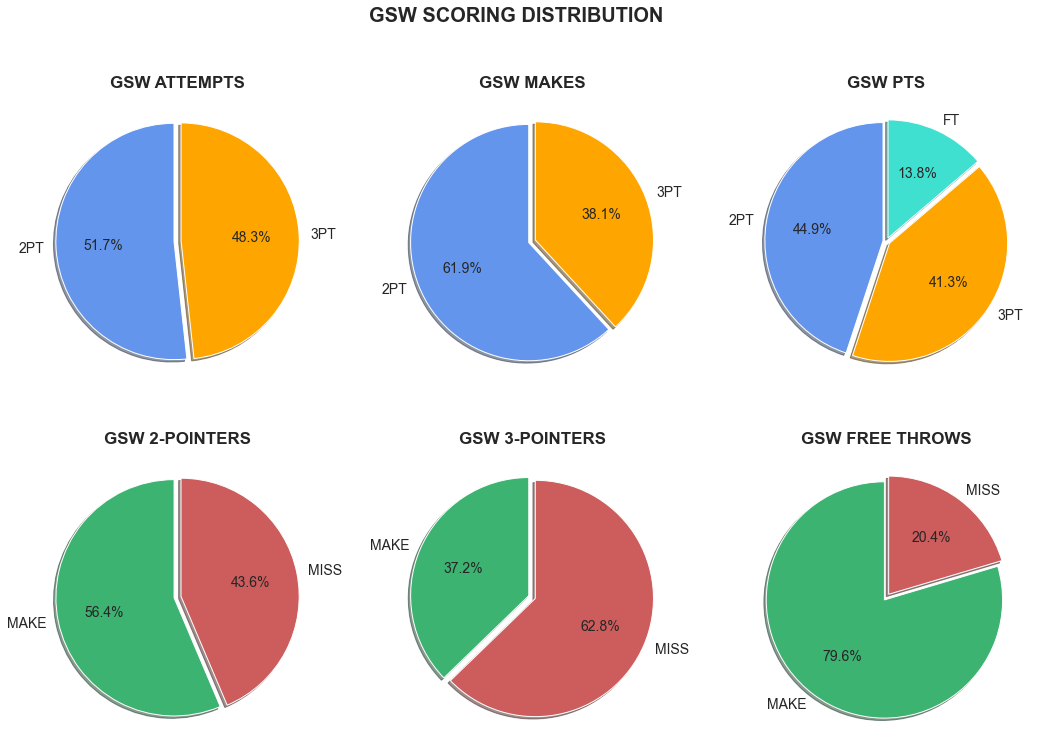

In [60]:
def shot_pies(team_abbr):
    
    df_team = df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr]
    
    data_att = [df_team.FRAC_ATT_2PT.item(), df_team.FRAC_ATT_3PT.item()]
    data_mk = [df_team.FRAC_MK_2PT.item(), df_team.FRAC_MK_3PT.item()]
    data_pts = [df_team.FRAC_PTS_2PT.item(), df_team.FRAC_PTS_3PT.item(), df_team.FRAC_PTS_FT.item()]
    
    data_2pt = [df_team.FG2M.item(), (df_team.FG2A.item() - df_team.FG2M.item())]
    data_3pt = [df_team.FG3M.item(), (df_team.FG3A.item() - df_team.FG3M.item())]
    data_ft = [df_team.FTM.item(), (df_team.FTA.item() - df_team.FTM.item())]
    
    labels1 = ['2PT', '3PT']
    labels2 = ['2PT', '3PT', 'FT']
    labels3 = ['MAKE', 'MISS']
    explode1 = [0.03, 0.03]
    explode2 = [0.03,0.03,0.03]
    colors0 = ['cornflowerblue', 'orange']
    colors1= ['cornflowerblue', 'orange', 'turquoise']
    colors2 = ['mediumseagreen','indianred']
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    
    ax[0,0].pie(data_att,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,0].set_title(f'{team_abbr} ATTEMPTS', fontsize=17, fontweight='bold')
    
    ax[0,1].pie(data_mk,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,1].set_title(f'{team_abbr} MAKES', fontsize=17, fontweight='bold')
    
    ax[0,2].pie(data_pts,
              labels=labels2,
              explode=explode2,
              shadow=True,
              colors=colors1,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,2].set_title(f'{team_abbr} PTS', fontsize=17, fontweight='bold')
    
    ax[1,0].pie(data_2pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,0].set_title(f'{team_abbr} 2-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,1].pie(data_3pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,1].set_title(f'{team_abbr} 3-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,2].pie(data_ft,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,2].set_title(f'{team_abbr} FREE THROWS', fontsize=17, fontweight='bold')
    
    fig.suptitle(f'{team_abbr} SCORING DISTRIBUTION', fontsize=20, fontweight="bold")
    plt.show()
    
shot_pies('GSW')

# Regrssion Analysis Plots ~ League Trends

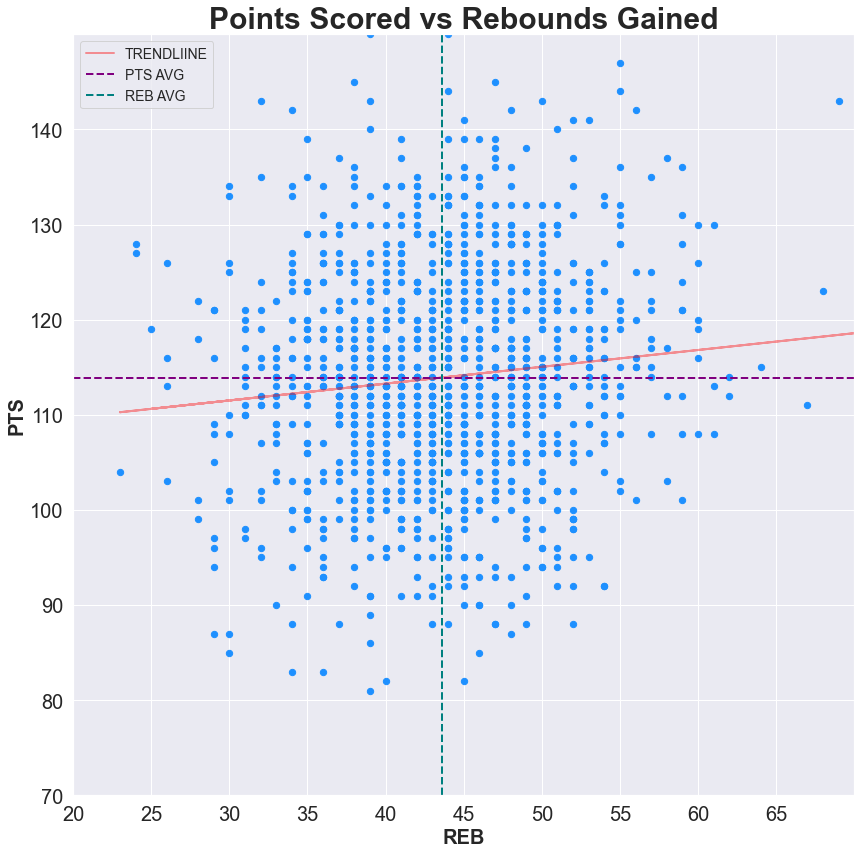

Season Trend Line Equation
y=0.176788x+(106.202267)

R-squared: 0.010557761870577664

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.3426
Date:                Sun, 15 Jan 2023   Prob (F-statistic):              0.563
Time:                        12:07:57   Log-Likelihood:                -75.914
No. Observations:                  31   AIC:                             155.8
Df Residuals:                      29   BIC:                             158.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [61]:
plt.rcParams["figure.figsize"] = (14,14)

x=df.REB
y=df.PTS

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.4, color='red', linewidth=2)

plt.scatter(x,y, color='dodgerblue', s=40)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.REB.mean(), label="REB AVG", linestyle='dashed', color='teal', linewidth=2)

plt.xlim(20,70)
plt.xticks(list(range(20,70,5)), fontsize=20)
plt.xlabel('REB', fontsize=20, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20)
plt.ylabel('PTS', fontsize=20, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Rebounds Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' +color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ REB', data=df_team_avg).fit()
print()
print(lm.summary())

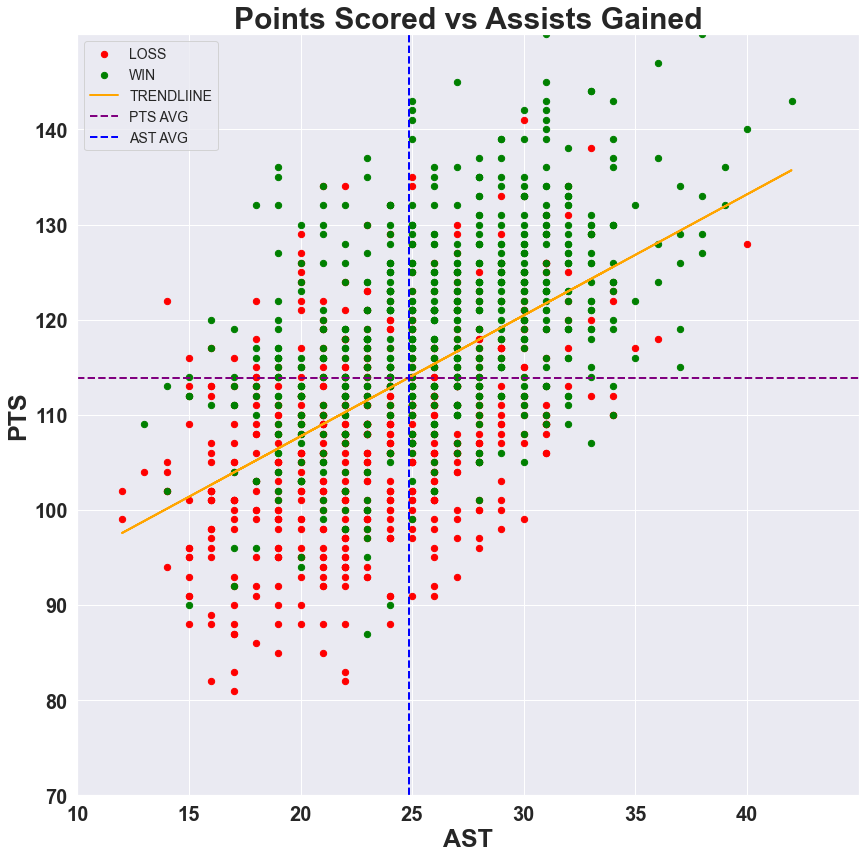

Season Trend Line Equation
y=1.271417x+(82.310488)

R-squared: 0.28669343772711886

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     24.03
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           3.33e-05
Time:                        12:07:58   Log-Likelihood:                -66.741
No. Observations:                  31   AIC:                             137.5
Df Residuals:                      29   BIC:                             140.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [62]:
plt.rcParams["figure.figsize"] = (14,14)

x=df.AST
y=df.PTS

x_L=df[df.WL=='L'].AST
y_L=df[df.WL=='L'].PTS

x_W=df[df.WL=='W'].AST
y_W=df[df.WL=='W'].PTS

plt.scatter(x_L,y_L, color='red', label='LOSS', s=40)
plt.scatter(x_W,y_W, color='green', label='WIN', s=40)

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=1, color='orange', linewidth=2)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.AST.mean(), label="AST AVG", linestyle='dashed', color='blue', linewidth=2)

plt.xlim(10,45)
plt.xticks(list(range(10,45,5)), fontsize=20, fontweight='bold')
plt.xlabel('AST', fontsize=25, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20, fontweight='bold')
plt.ylabel('PTS', fontsize=25, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Assists Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' + color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ AST', data=df_team_avg).fit()
print()
print(lm.summary())

## Team Average Reression (statx vs staty) Plot and Analysis Function

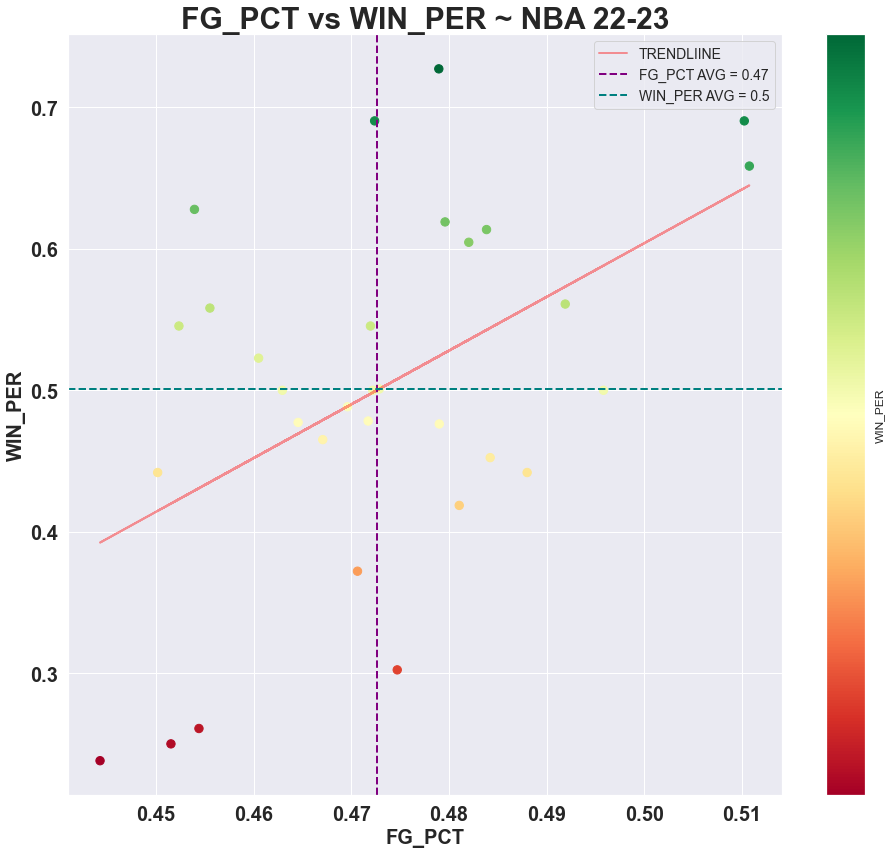


Season Trend Line Equation: y = 3.798479x + (-1.295205)

R-squared: 0.2433720462011817


                            OLS Regression Results                            
Dep. Variable:                WIN_PER   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     9.328
Date:                Sun, 15 Jan 2023   Prob (F-statistic):            0.00480
Time:                        12:08:26   Log-Likelihood:                 25.012
No. Observations:                  31   AIC:                            -46.02
Df Residuals:                      29   BIC:                            -43.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [64]:
def regression_analysis_team_avg(statx, staty):
    plt.rcParams["figure.figsize"] = (16,14)

    x=df_team_avg[statx]
    y=df_team_avg[staty]

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.4, color='red', linewidth=2)

    plt.scatter(x,y, c=y, cmap='RdYlGn', s=70)

    plt.axvline(df.FG_PCT.mean(), label=f"{statx} AVG = {round(df_team_avg[df_team_avg['TEAM_ABBR']=='NBA'][statx].item(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(df_team_avg.WIN_PER.mean(), label=f"{staty} AVG = {round(df_team_avg[df_team_avg['TEAM_ABBR']=='NBA'][staty].item(),2)}", linestyle='dashed', color='teal', linewidth=2)

    plt.xlabel(statx, fontsize=20, fontweight='bold')
    plt.ylabel(staty, fontsize=20, fontweight='bold')

    plt.legend(loc='best', fontsize=14)

    plt.title(f'{statx} vs {staty} ~ NBA 22-23', fontsize=30, fontweight='bold')
    plt.colorbar(label=staty, ticks=np.linspace(0.2,0.,8))
    plt.xticks(fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()

    lm = smf.ols(formula = f'{staty} ~ {statx}', data=df_team_avg).fit()
    print()
    print(lm.summary())
    

regression_analysis_team_avg('FG_PCT', 'WIN_PER')

# Team Report Function

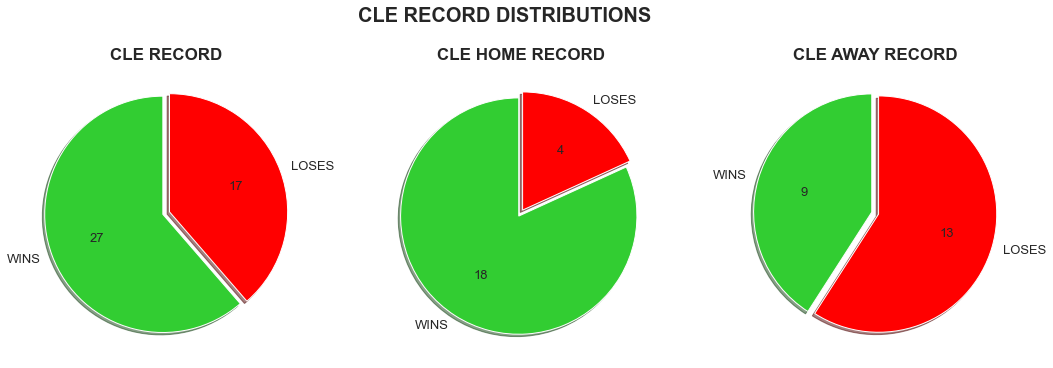

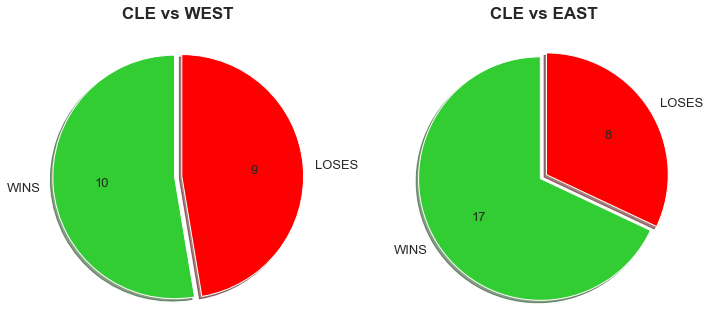

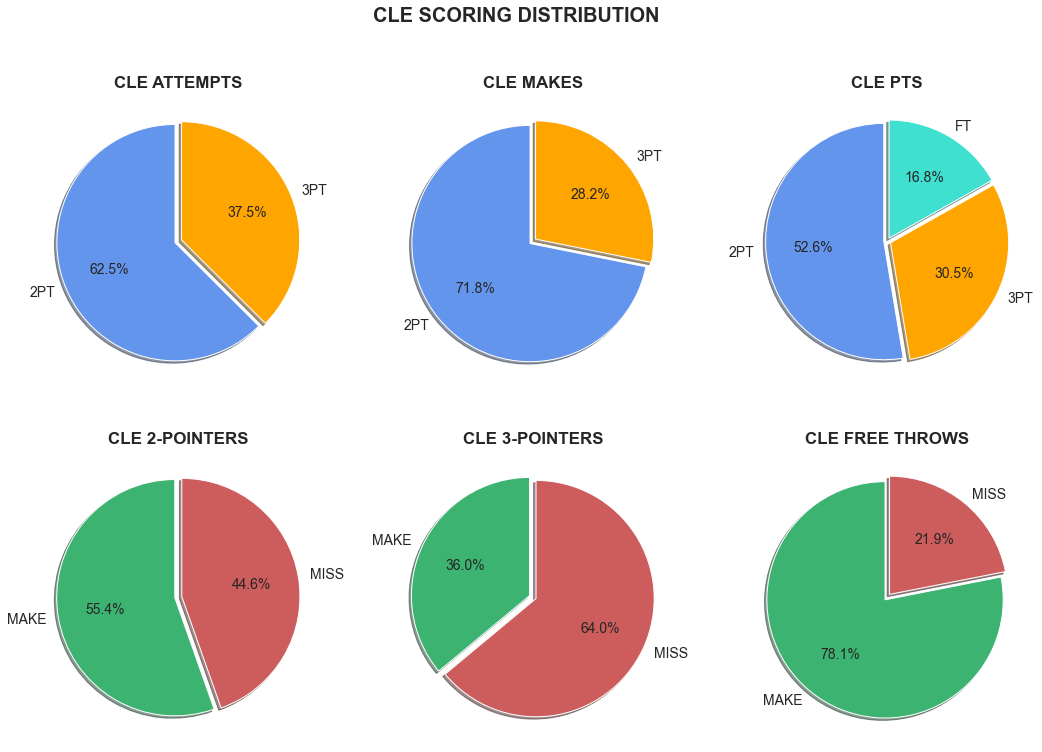

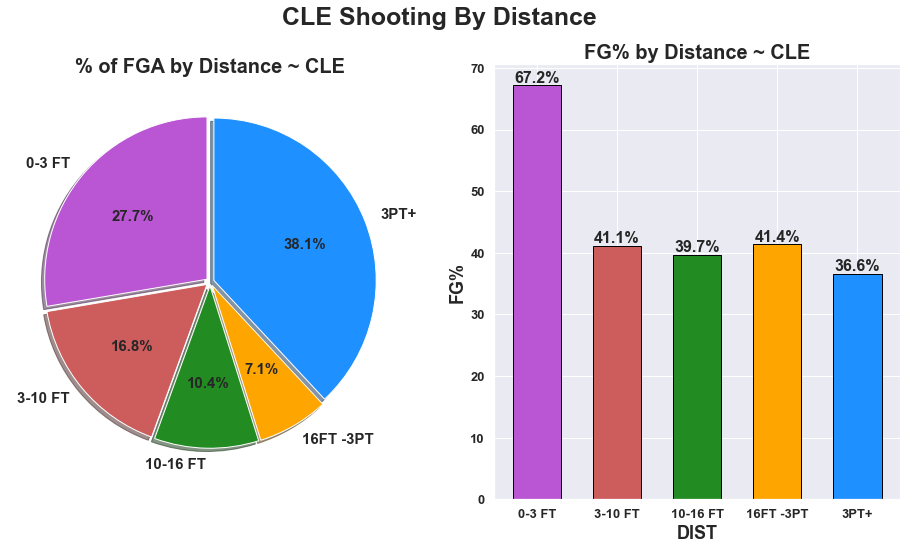

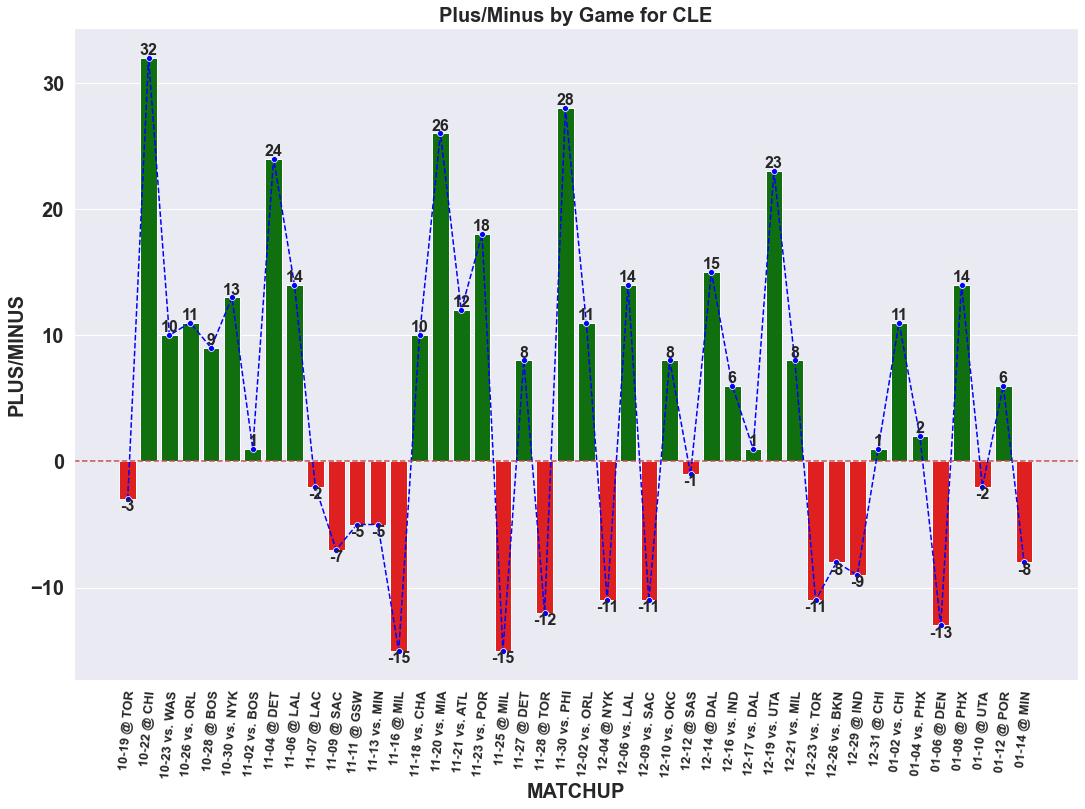

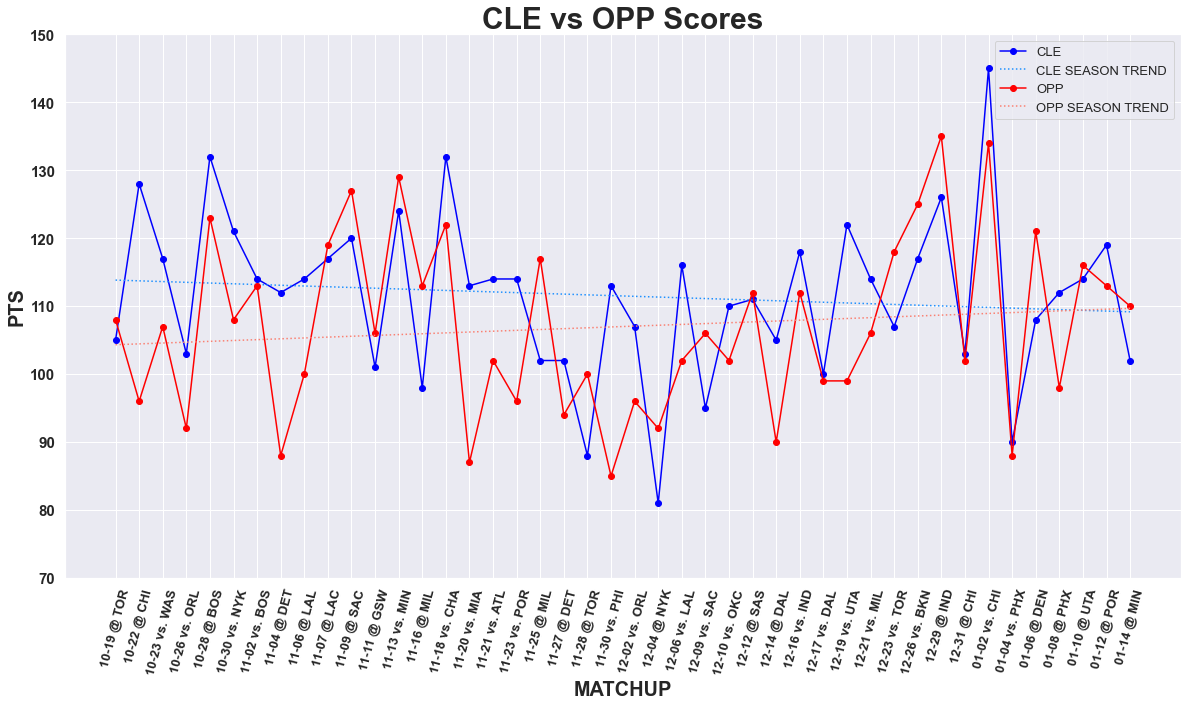

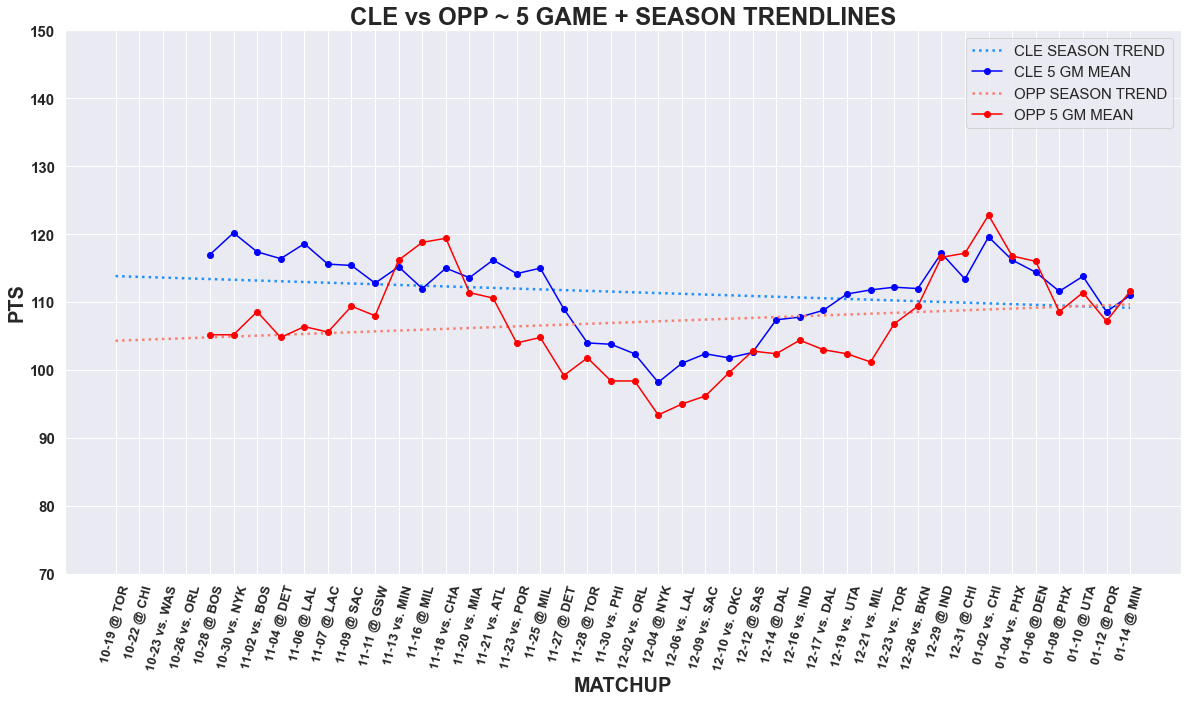

In [67]:
#NBA TEAM REPORT

def team_report(team_abbr):
    wl_pies(team_abbr)
    shot_pies(team_abbr)
    team_fg_by_dist(team_abbr)
    plus_minus_plot(team_abbr)
    line_plot_scores(team_abbr)
    trend_plot_scores(team_abbr)
    
team_report("CLE")

# 2-Team Comparison Function

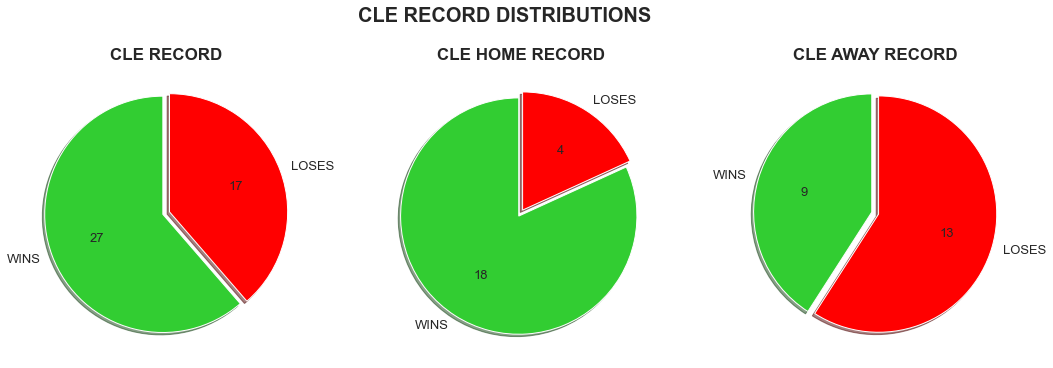

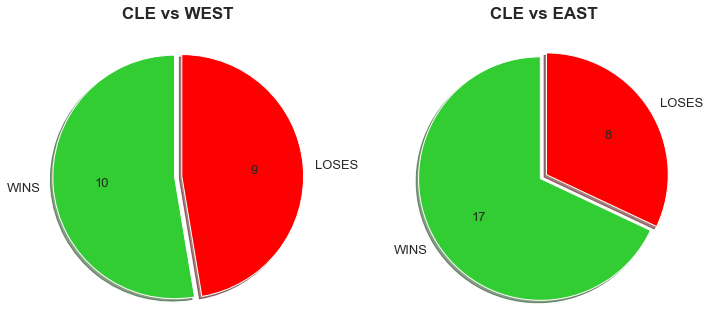

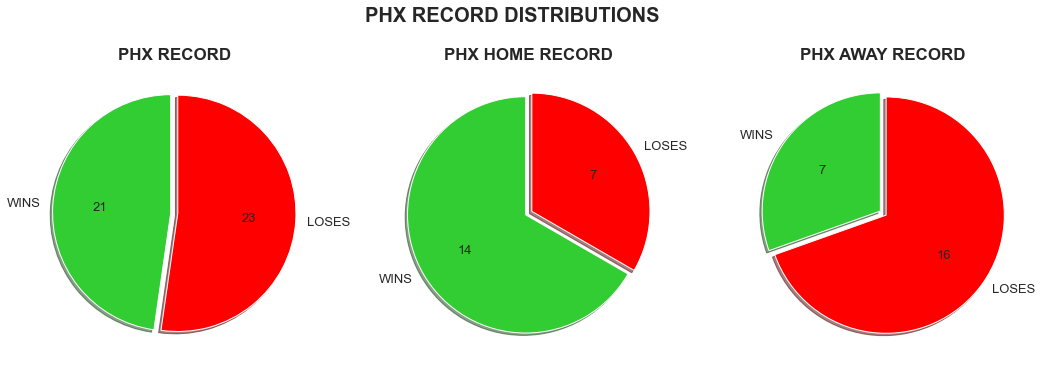

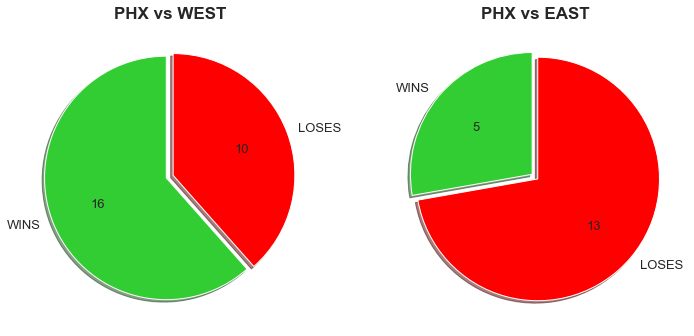

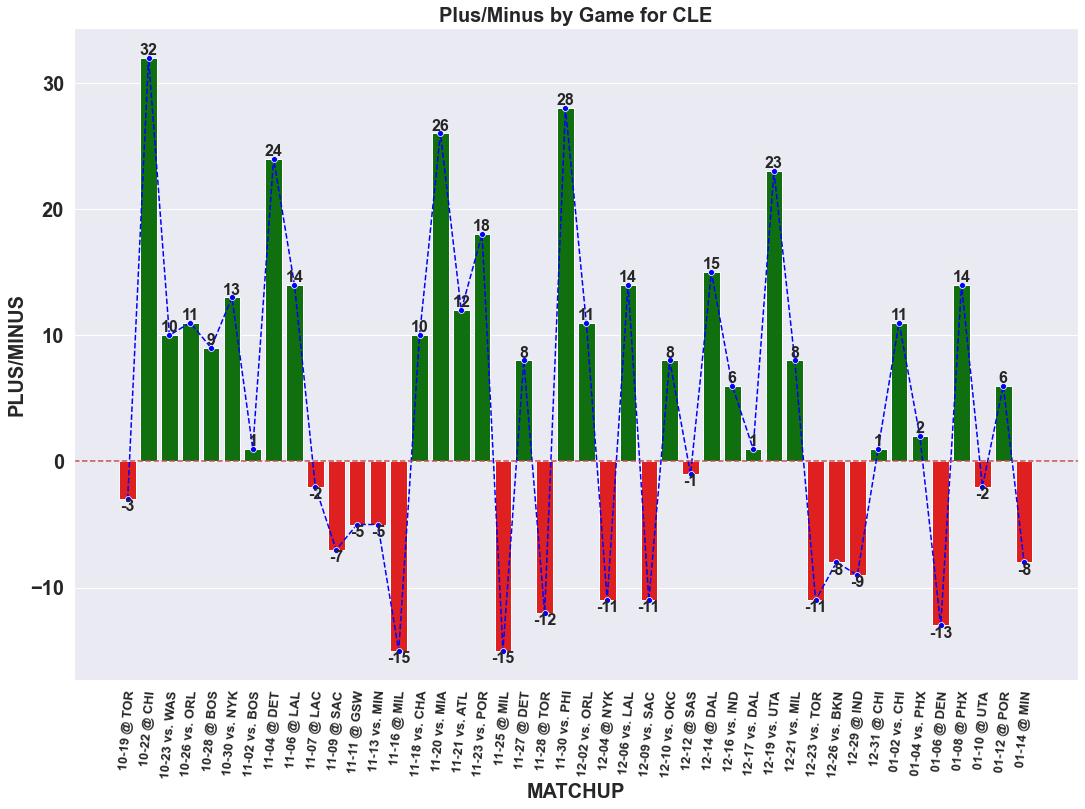

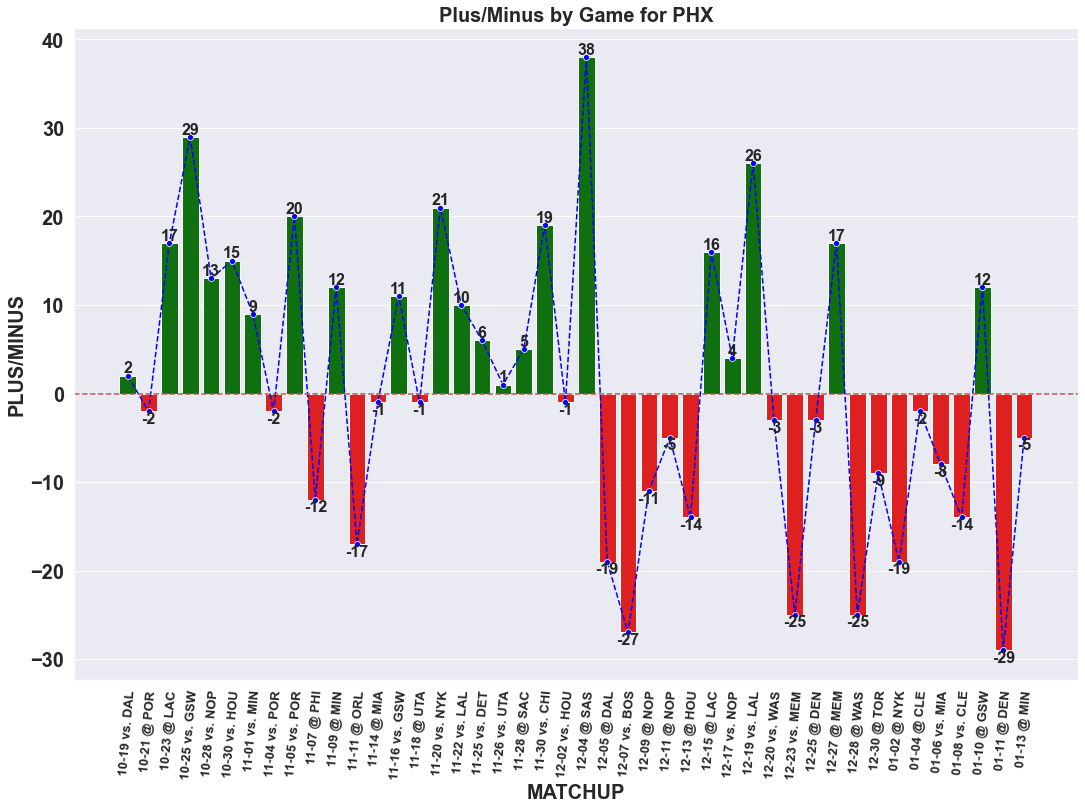

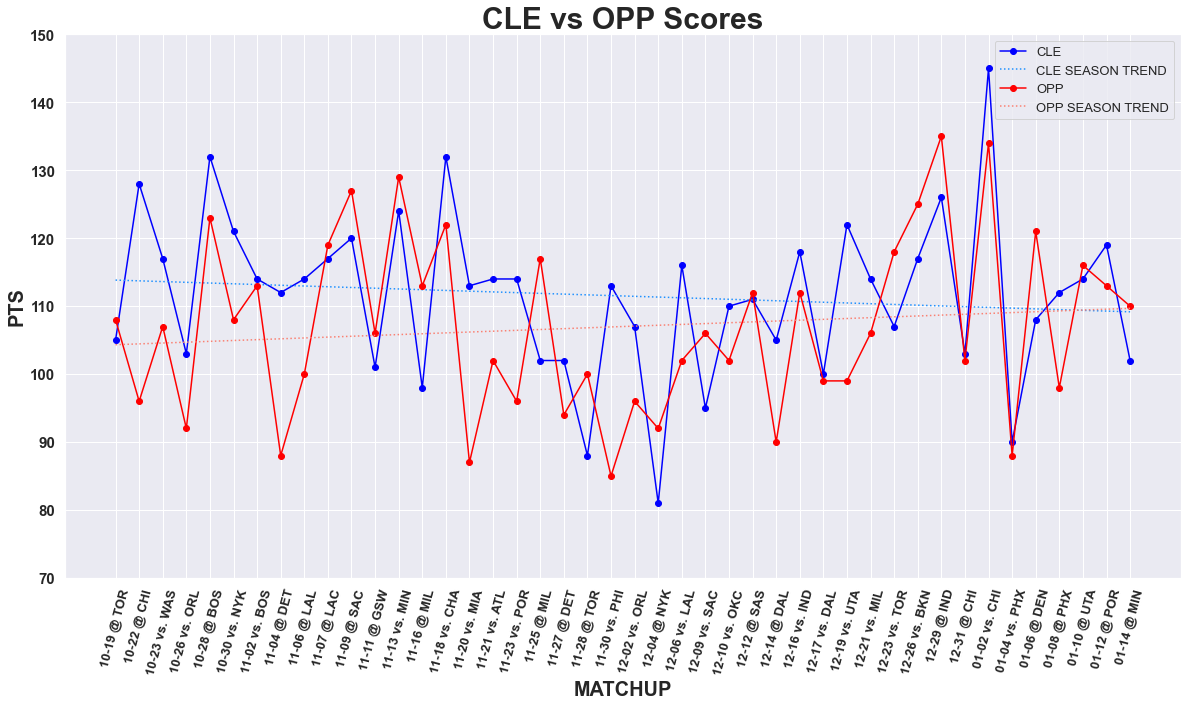

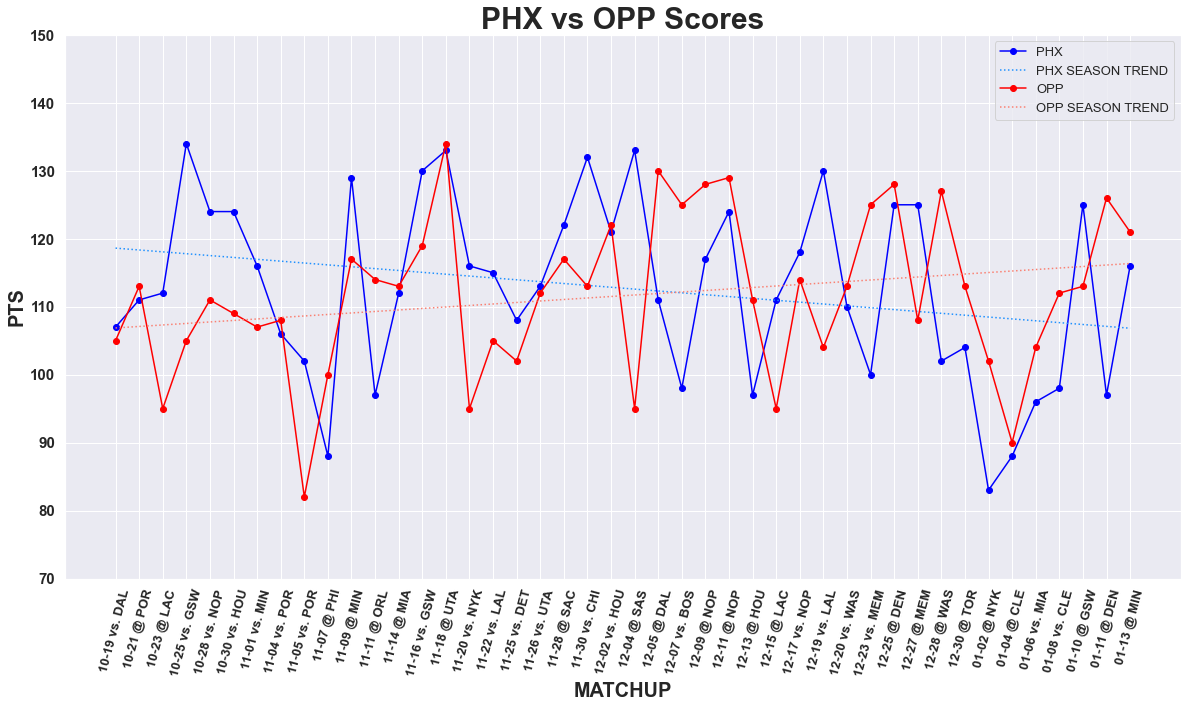

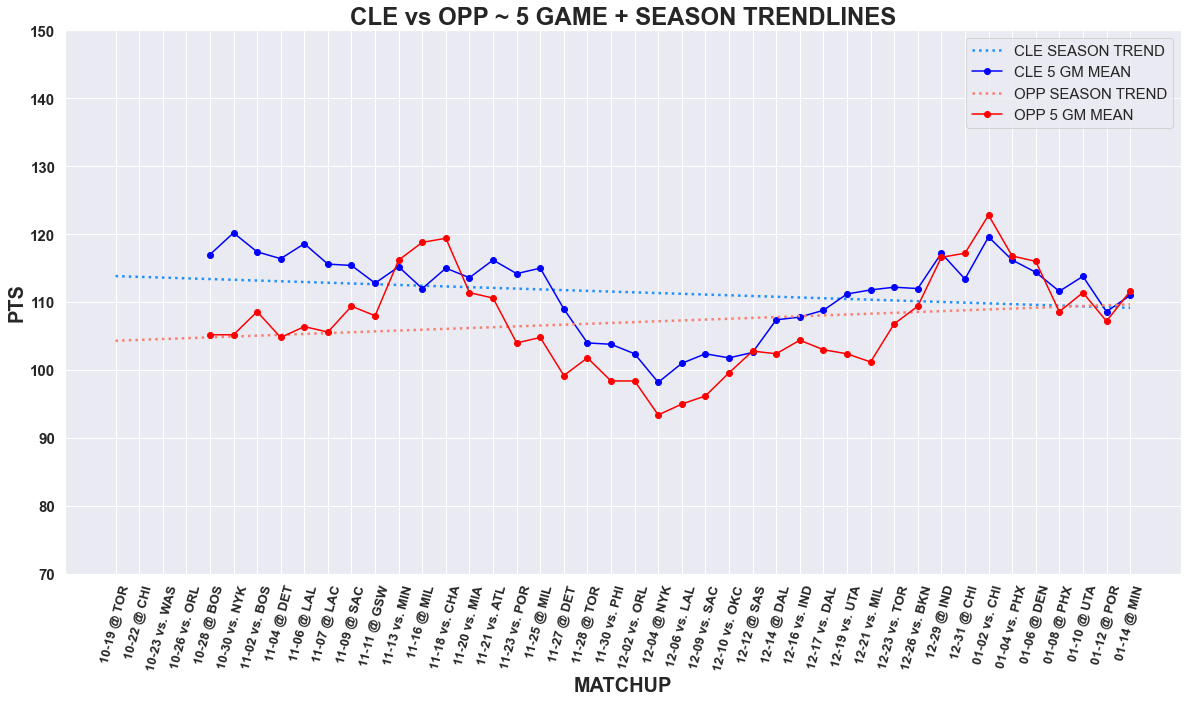

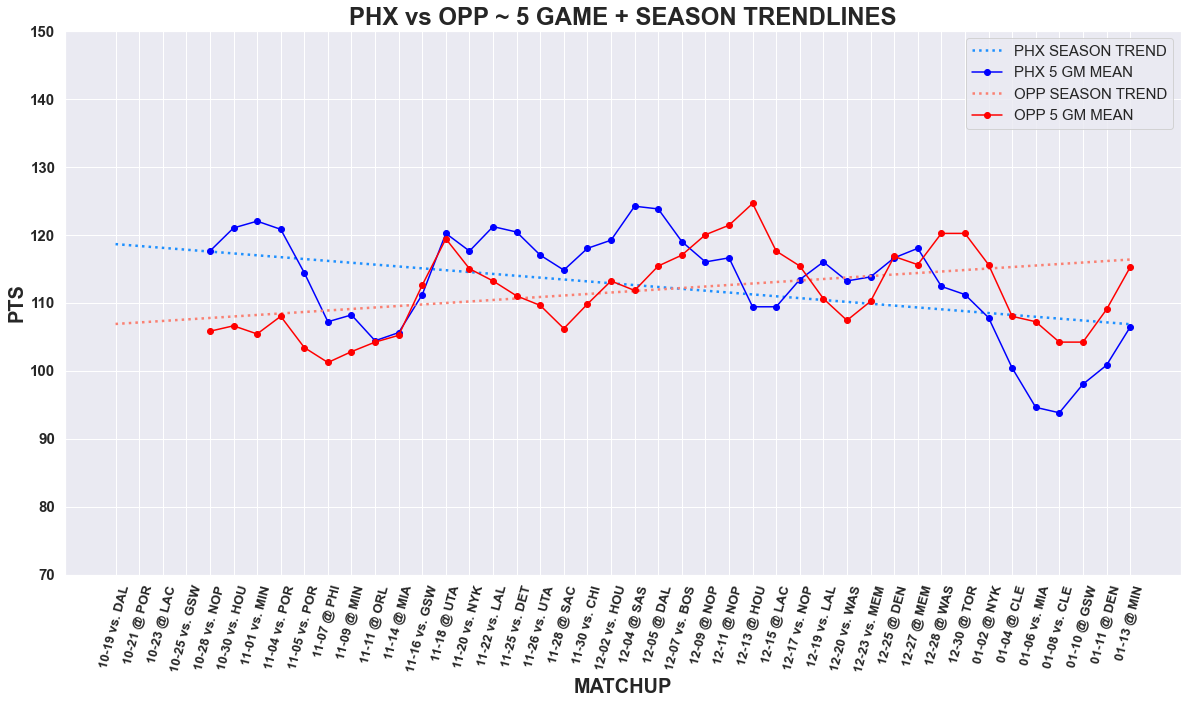

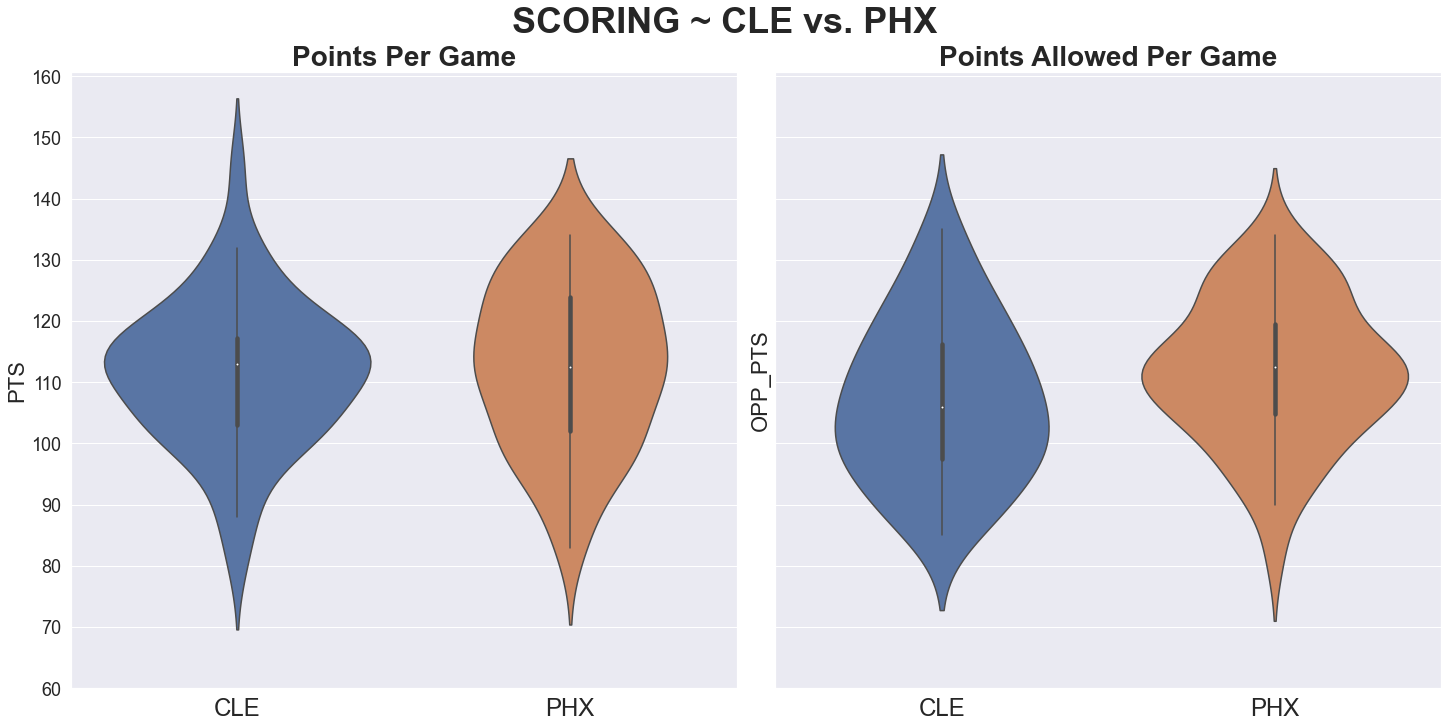

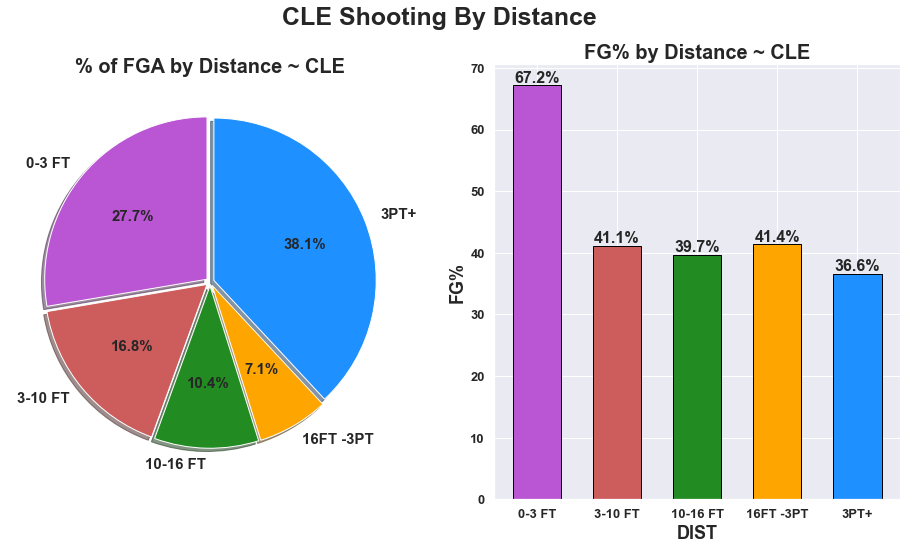

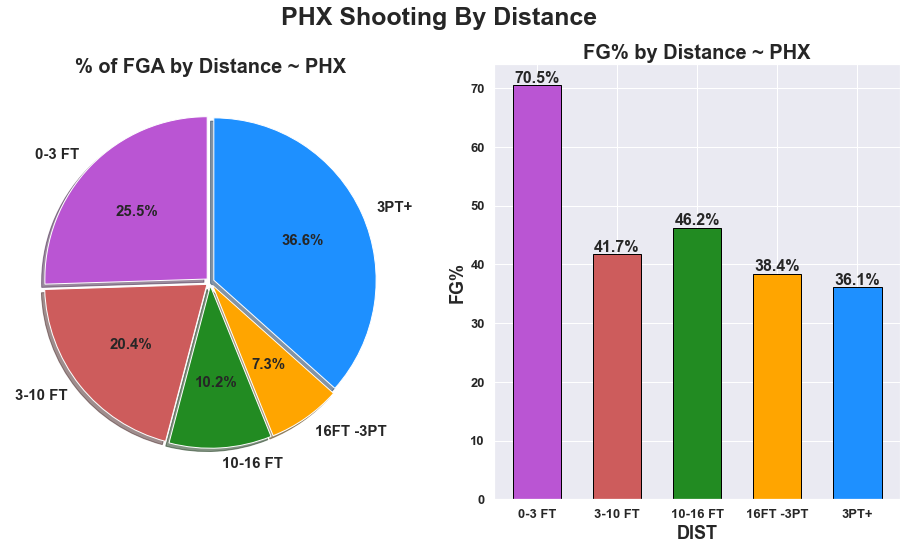

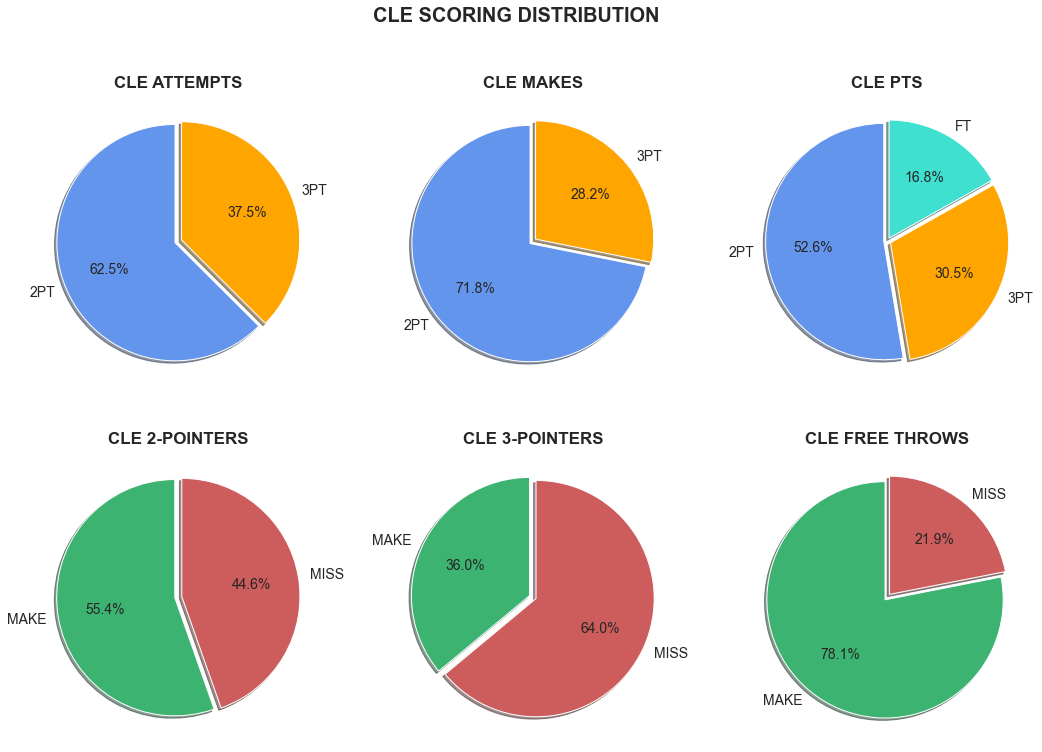

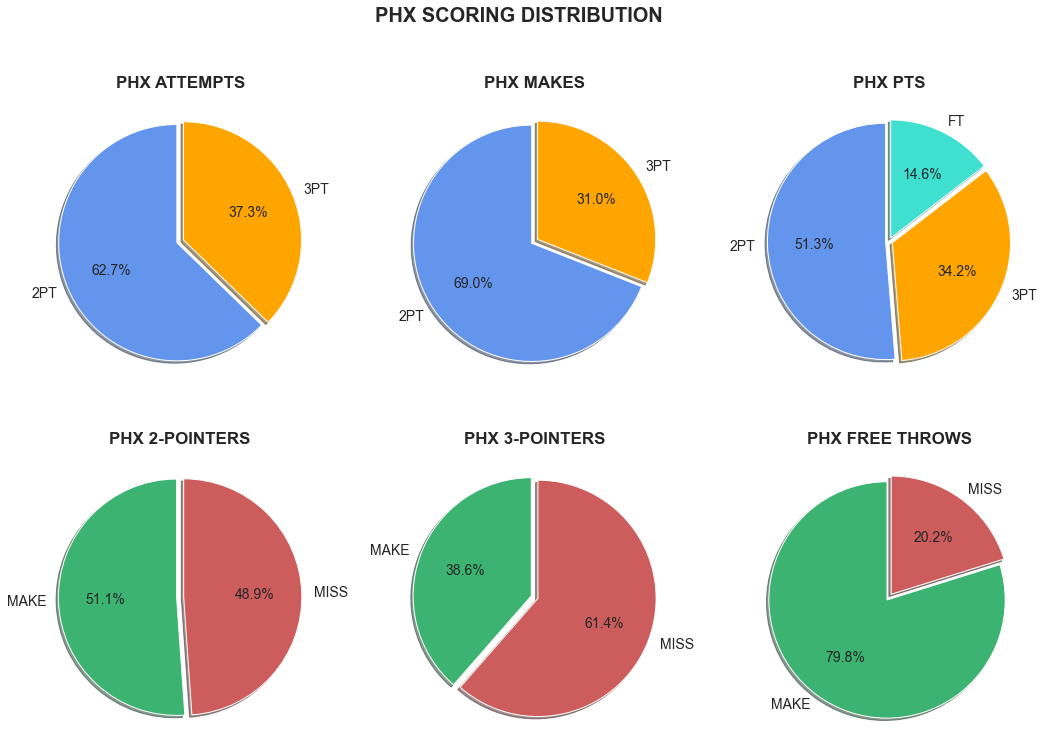

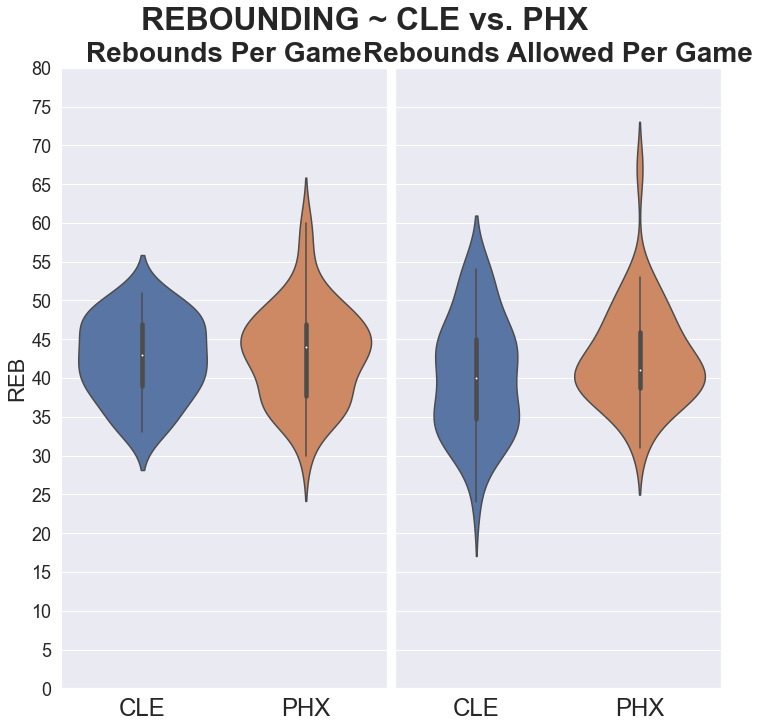

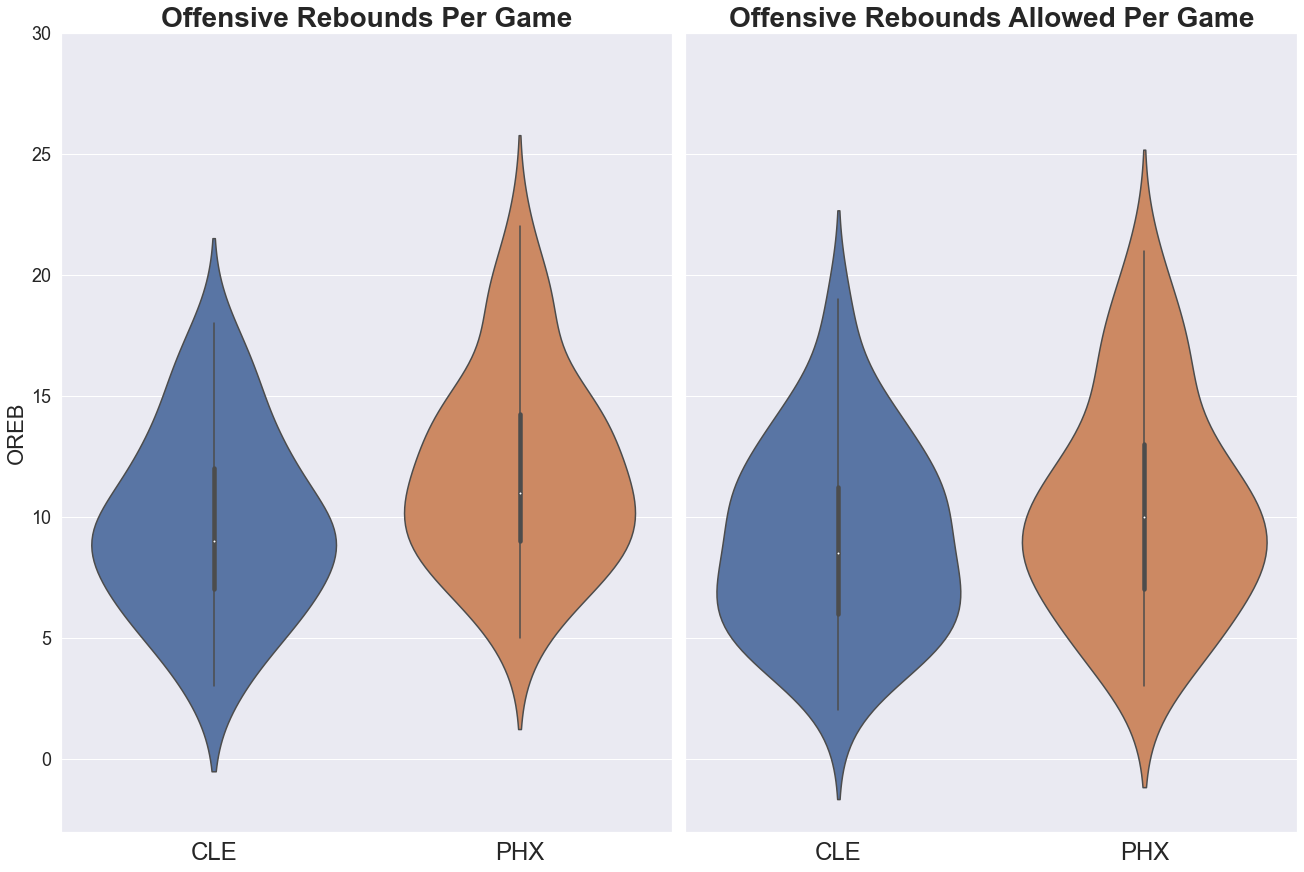

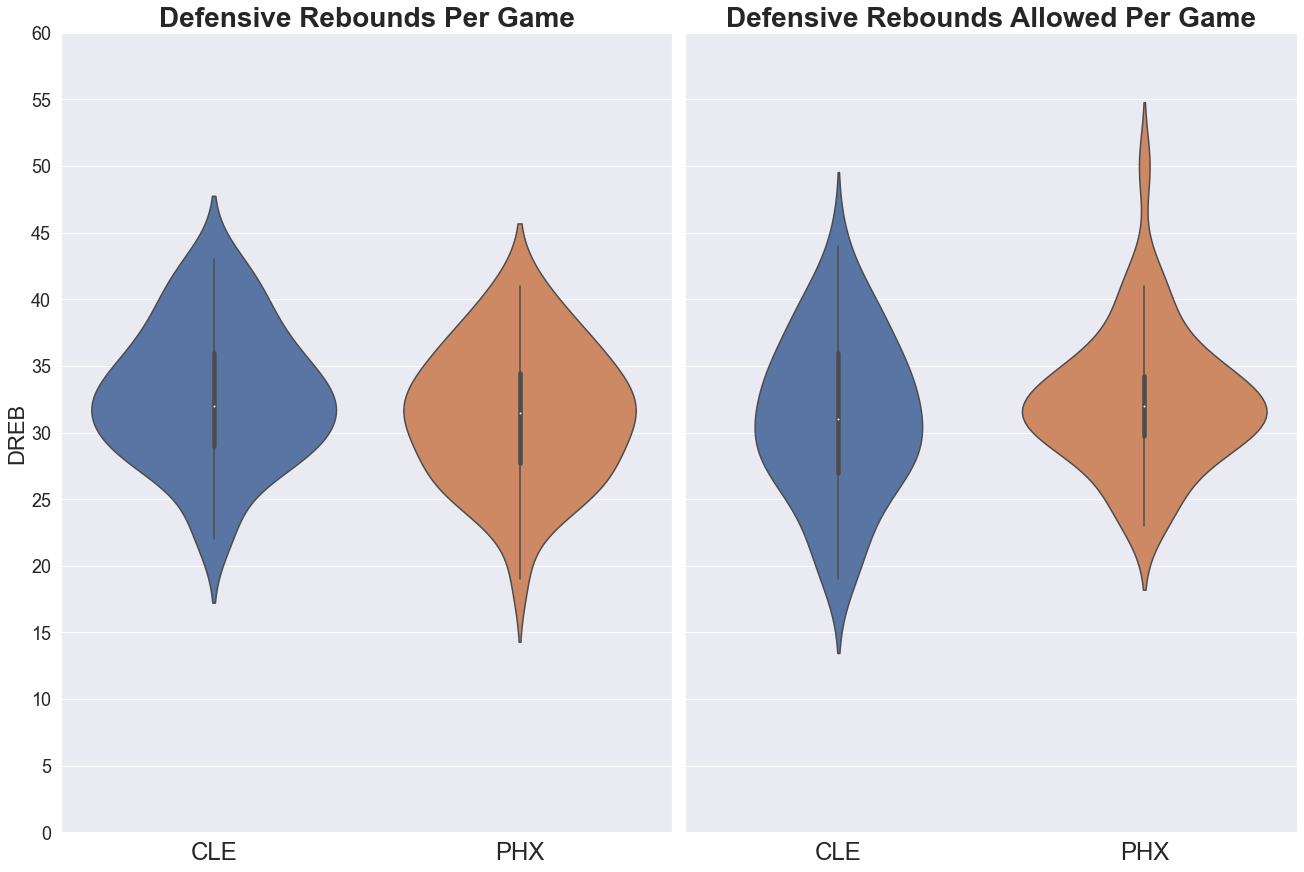

In [68]:
def compare_teams(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])
    
    wl_pies(team_a_abbr)
    wl_pies(team_b_abbr)
    
    plus_minus_plot(team_a_abbr)
    plus_minus_plot(team_b_abbr)
    
    line_plot_scores(team_a_abbr)
    line_plot_scores(team_b_abbr)
    
    trend_plot_scores(team_a_abbr)
    trend_plot_scores(team_b_abbr)
    
    scored_allowed_compare(team_a_abbr, team_b_abbr)
    
    team_fg_by_dist(team_a_abbr)
    team_fg_by_dist(team_b_abbr)
    
    shot_pies(team_a_abbr)
    shot_pies(team_b_abbr)
    
    rebounds_compare(team_a_abbr, team_b_abbr)
    
    plt.show()

compare_teams('CLE','PHX')